<a href="https://colab.research.google.com/github/yashrajbista/thesis_project/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os

In [8]:
# Mount Google Drive first
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=False)
print("✅ Drive mounted!\n")

# Define project path
project_path = '/content/drive/MyDrive/oracle-log-anomaly-detection'

print("="*60)
print("CREATING PROJECT STRUCTURE")
print("="*60)
print()

# Create the main project directory if it doesn't exist
if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"✅ Created main project folder: oracle-log-anomaly-detection/\n")
else:
    print(f"✅ Main project folder already exists\n")

# Navigate to the project folder
os.chdir(project_path)

# Create all subfolders
subfolders = ['data', 'models', 'results', 'notebooks']

for folder in subfolders:
    folder_path = os.path.join(project_path, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"✅ Created: {folder}/")
    else:
        print(f"✅ Already exists: {folder}/")

print()
print("="*60)
print("PROJECT STRUCTURE COMPLETE!")
print("="*60)
print(f"\nCurrent directory: {os.getcwd()}")
print(f"\n📁 My project structure:")
print("oracle-log-anomaly-detection/")
for folder in subfolders:
    print(f"  ├── {folder}/")
print()


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted!

CREATING PROJECT STRUCTURE

✅ Main project folder already exists

✅ Already exists: data/
✅ Already exists: models/
✅ Already exists: results/
✅ Already exists: notebooks/

PROJECT STRUCTURE COMPLETE!

Current directory: /content/drive/MyDrive/oracle-log-anomaly-detection

📁 My project structure:
oracle-log-anomaly-detection/
  ├── data/
  ├── models/
  ├── results/
  ├── notebooks/



In [9]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import joblib
import json
import sklearn
import warnings
warnings.filterwarnings('ignore')
import re
from datetime import datetime

In [10]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("ENVIRONMENT VERIFICATION")
print("="*60)
print()
print(f"✅ NumPy: {np.__version__}")
print(f"✅ Pandas: {pd.__version__}")
print(f"✅ Scikit-learn: {sklearn.__version__}")
print(f"✅ Matplotlib version: 3.x")
print(f"✅ Seaborn: {sns.__version__}")


ENVIRONMENT VERIFICATION

✅ NumPy: 2.0.2
✅ Pandas: 2.2.2
✅ Scikit-learn: 1.6.1
✅ Matplotlib version: 3.x
✅ Seaborn: 0.13.2


In [11]:
# Check GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(f"\n🖥️  GPU Available: {len(gpus) > 0}")
if len(gpus) > 0:
    print(f"   GPU Type: {gpus[0].name}")
else:
    print("   Using CPU (You can enable GPU: Runtime → Change runtime type → GPU)")

print()
print("="*60)
print("✅ ALL SYSTEMS READY!")
print("="*60)
print()
print("You can now:")
print("• Upload your Oracle logs to the 'data' folder")
print("• Start data preprocessing")
print("• Train your ML models")
print("• Save results automatically to Google Drive")


🖥️  GPU Available: False
   Using CPU (You can enable GPU: Runtime → Change runtime type → GPU)

✅ ALL SYSTEMS READY!

You can now:
• Upload your Oracle logs to the 'data' folder
• Start data preprocessing
• Train your ML models
• Save results automatically to Google Drive


In [12]:
print("="*60)
print("PARSING ORACLE ALERT LOG")
print("="*60)
print()

# Read the raw text file
file_path = '/content/drive/MyDrive/oracle-log-anomaly-detection/data/alertbildc1.txt'

with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    log_content = f.read()

print(f"✅ Loaded file: {len(log_content)} characters")
print(f"✅ File size: {len(log_content)/1024:.2f} KB")
print()

PARSING ORACLE ALERT LOG

✅ Loaded file: 72015268 characters
✅ File size: 70327.41 KB



In [13]:
# Show first 1000 characters to understand structure
print("First 1000 characters of log:")
print("-" * 60)
print(log_content[:1000])
print("-" * 60)

First 1000 characters of log:
------------------------------------------------------------
Fri Oct 18 02:08:02 2024
Adjusting the requested value of parameter parallel_max_servers
from 2048 to 1985 due to the value of parameter processes (2000)
Starting ORACLE instance (normal)
LICENSE_MAX_SESSION = 0
LICENSE_SESSIONS_WARNING = 0
Private Interface 'net0:1' configured from GPnP for use as a private interconnect.
  [name='net0:1', type=1, ip=169.254.109.99, mac=00-10-e0-d5-63-fe-00-00-00-00-00-00-00-00-00-00-00-2f-ff-ff, net=169.254.0.0/17, mask=255.255.128.0, use=haip:cluster_interconnect/62]
Private Interface 'net3:1' configured from GPnP for use as a private interconnect.
  [name='net3:1', type=1, ip=169.254.202.138, mac=00-10-e0-d5-64-01-00-00-00-00-00-00-00-00-00-00-00-2f-ff-ff, net=169.254.128.0/17, mask=255.255.128.0, use=haip:cluster_interconnect/62]
Public Interface 'ipmp0' configured from GPnP for use as a public interface.
  [name='ipmp0', type=1, ip=172.20.33.11, mac=00-10-e0

In [14]:
"""
Parse Oracle Alert Log into structured format
"""

def parse_oracle_alert_log(content):
    """
    Parse Oracle alert log text into structured records
    """
    records = []

    # Split by common Oracle log patterns
    # Oracle logs typically have timestamps like:
    # Wed Nov 01 10:30:45 2023
    # or: 2023-11-01T10:30:45.123456+00:00

    lines = content.split('\n')

    current_entry = {
        'timestamp': None,
        'message': '',
        'raw_text': ''
    }

    # Timestamp patterns
    timestamp_pattern = r'(\w{3}\s+\w{3}\s+\d{2}\s+\d{2}:\d{2}:\d{2}\s+\d{4})'
    iso_timestamp_pattern = r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})'

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Check if line starts with timestamp
        timestamp_match = re.search(timestamp_pattern, line)
        iso_match = re.search(iso_timestamp_pattern, line)

        if timestamp_match or iso_match:
            # Save previous entry if it has content
            if current_entry['timestamp'] is not None:
                records.append(current_entry.copy())

            # Start new entry
            current_entry = {
                'timestamp': timestamp_match.group(1) if timestamp_match else iso_match.group(1),
                'message': line,
                'raw_text': line
            }
        else:
            # Continue current entry
            current_entry['message'] += ' ' + line
            current_entry['raw_text'] += '\n' + line

    # Add last entry
    if current_entry['timestamp'] is not None:
        records.append(current_entry)

    return records

# Parse the log
print("Parsing log entries...")
records = parse_oracle_alert_log(log_content)

print(f"✅ Parsed {len(records)} log entries")
print()

# Create DataFrame
df = pd.DataFrame(records)

print("First 5 parsed entries:")
print(df.head())

Parsing log entries...
✅ Parsed 446678 log entries

First 5 parsed entries:
                  timestamp  \
0  Fri Oct 18 02:08:02 2024   
1  Fri Oct 18 02:08:11 2024   
2  Fri Oct 18 02:08:11 2024   
3  Fri Oct 18 02:08:12 2024   
4  Fri Oct 18 02:08:12 2024   

                                             message  \
0  Fri Oct 18 02:08:02 2024 Adjusting the request...   
1  Fri Oct 18 02:08:11 2024 PMON started with pid...   
2  Fri Oct 18 02:08:11 2024 PSP0 started with pid...   
3  Fri Oct 18 02:08:12 2024 VKTM started with pid...   
4  Fri Oct 18 02:08:12 2024 GEN0 started with pid...   

                                            raw_text  
0  Fri Oct 18 02:08:02 2024\nAdjusting the reques...  
1  Fri Oct 18 02:08:11 2024\nPMON started with pi...  
2  Fri Oct 18 02:08:11 2024\nPSP0 started with pi...  
3  Fri Oct 18 02:08:12 2024\nVKTM started with pi...  
4  Fri Oct 18 02:08:12 2024\nGEN0 started with pi...  


In [15]:
"""
Extract features from log messages
"""

def extract_log_features(df):
    """
    Extract features from Oracle alert log messages
    """
    # Clean messages
    df['message_clean'] = df['message'].str.strip()

    # Extract error codes (ORA-XXXXX)
    df['error_code'] = df['message'].str.extract(r'(ORA-\d{5})', expand=False)
    df['has_error'] = df['error_code'].notna().astype(int)

    # Determine log level based on keywords
    def determine_log_level(msg):
        msg_lower = msg.lower()
        if 'error' in msg_lower or 'ora-' in msg_lower:
            return 'ERROR'
        elif 'warning' in msg_lower or 'warn' in msg_lower:
            return 'WARNING'
        elif 'fatal' in msg_lower or 'critical' in msg_lower:
            return 'CRITICAL'
        else:
            return 'INFO'

    df['log_level'] = df['message'].apply(determine_log_level)

    # Extract common patterns
    df['has_deadlock'] = df['message'].str.contains('deadlock', case=False, na=False).astype(int)
    df['has_tablespace'] = df['message'].str.contains('tablespace', case=False, na=False).astype(int)
    df['has_archival'] = df['message'].str.contains('archiv', case=False, na=False).astype(int)
    df['has_checkpoint'] = df['message'].str.contains('checkpoint', case=False, na=False).astype(int)
    df['has_startup'] = df['message'].str.contains('startup|starting', case=False, na=False).astype(int)
    df['has_shutdown'] = df['message'].str.contains('shutdown|shutting', case=False, na=False).astype(int)

    # Message length as a feature
    df['message_length'] = df['message'].str.len()

    return df

# Extract features
df = extract_log_features(df)

print("✅ Extracted features from messages")
print()
print("Feature summary:")
print(f"  Total entries: {len(df)}")
print(f"  Entries with errors: {df['has_error'].sum()}")
print(f"  Error rate: {df['has_error'].mean()*100:.2f}%")
print()
print("Log level distribution:")
print(df['log_level'].value_counts())

✅ Extracted features from messages

Feature summary:
  Total entries: 446678
  Entries with errors: 484
  Error rate: 0.11%

Log level distribution:
log_level
INFO       420875
ERROR       25732
WARNING        71
Name: count, dtype: int64


In [16]:
df


,timestamp,message,raw_text,message_clean,error_code,has_error,log_level,has_deadlock,has_tablespace,has_archival,has_checkpoint,has_startup,has_shutdown,message_length
0,Fri Oct 18 02:08:02 2024,Fri Oct 18 02:08:02 2024 Adjusting the request...,Fri Oct 18 02:08:02 2024\nAdjusting the reques...,Fri Oct 18 02:08:02 2024 Adjusting the request...,NaN,0,WARNING,0,1,1,0,1,0,3528
1,Fri Oct 18 02:08:11 2024,Fri Oct 18 02:08:11 2024 PMON started with pid...,Fri Oct 18 02:08:11 2024\nPMON started with pi...,Fri Oct 18 02:08:11 2024 PMON started with pid...,NaN,0,INFO,0,0,0,0,0,0,60
2,Fri Oct 18 02:08:11 2024,Fri Oct 18 02:08:11 2024 PSP0 started with pid...,Fri Oct 18 02:08:11 2024\nPSP0 started with pi...,Fri Oct 18 02:08:11 2024 PSP0 started with pid...,NaN,0,INFO,0,0,0,0,0,0,60
3,Fri Oct 18 02:08:12 2024,Fri Oct 18 02:08:12 2024 VKTM started with pid...,Fri Oct 18 02:08:12 2024\nVKTM started with pi...,Fri Oct 18 02:08:12 2024 VKTM started with pid...,NaN,0,INFO,0,0,0,0,0,0,145
4,Fri Oct 18 02:08:12 2024,Fri Oct 18 02:08:12 2024 GEN0 started with pid...,Fri Oct 18 02:08:12 2024\nGEN0 started with pi...,Fri Oct 18 02:08:12 2024 GEN0 started with pid...,NaN,0,INFO,0,0,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446673,Sun Nov 02 11:32:46 2025,Sun Nov 02 11:32:46 2025 Archived Log entry 69...,Sun Nov 02 11:32:46 2025\nArchived Log entry 6...,Sun Nov 02 11:32:46 2025 Archived Log entry 69...,NaN,0,INFO,0,0,1,0,0,0,116
446674,Sun Nov 02 11:35:31 2025,Sun Nov 02 11:35:31 2025 Thread 1 advanced to ...,Sun Nov 02 11:35:31 2025\nThread 1 advanced to...,Sun Nov 02 11:35:31 2025 Thread 1 advanced to ...,NaN,0,INFO,0,0,0,0,0,0,149
446675,Sun Nov 02 11:35:33 2025,Sun Nov 02 11:35:33 2025 Archived Log entry 69...,Sun Nov 02 11:35:33 2025\nArchived Log entry 6...,Sun Nov 02 11:35:33 2025 Archived Log entry 69...,NaN,0,INFO,0,0,1,0,0,0,116
446676,Sun Nov 02 11:38:28 2025,Sun Nov 02 11:38:28 2025 Thread 1 advanced to ...,Sun Nov 02 11:38:28 2025\nThread 1 advanced to...,Sun Nov 02 11:38:28 2025 Thread 1 advanced to ...,NaN,0,INFO,0,0,0,0,0,0,149


In [17]:
"""
Parse and process timestamps - FIXED
"""

# First, ensure timestamp is datetime
print("Converting timestamps to datetime...")
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Check for any NaN after conversion
nan_count = df['timestamp'].isna().sum()
if nan_count > 0:
    print(f"⚠️  Found {nan_count} invalid timestamps, removing them...")
    df = df.dropna(subset=['timestamp']).reset_index(drop=True)

print(f"✅ Parsed timestamps: {len(df):,} valid entries")
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Data type: {df['timestamp'].dtype}")
print()

# NOW extract time features (this should work)
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_business_hours'] = df['hour'].between(9, 17).astype(int)

print("✅ Time features extracted")
print()
print("Sample of parsed data:")
print(df[['timestamp', 'hour', 'day_of_week', 'is_weekend']].head(10))

Converting timestamps to datetime...
✅ Parsed timestamps: 446,678 valid entries
Time range: 2024-10-18 02:08:02 to 2025-11-02 11:38:30
Data type: datetime64[ns]

✅ Time features extracted

Sample of parsed data:
            timestamp  hour  day_of_week  is_weekend
0 2024-10-18 02:08:02     2            4           0
1 2024-10-18 02:08:11     2            4           0
2 2024-10-18 02:08:11     2            4           0
3 2024-10-18 02:08:12     2            4           0
4 2024-10-18 02:08:12     2            4           0
5 2024-10-18 02:08:12     2            4           0
6 2024-10-18 02:08:12     2            4           0
7 2024-10-18 02:08:12     2            4           0
8 2024-10-18 02:08:12     2            4           0
9 2024-10-18 02:08:12     2            4           0


In [18]:
"""
Create statistical and temporal features
"""

# Log severity
log_severity = {'INFO': 0, 'WARNING': 1, 'ERROR': 2, 'CRITICAL': 3}
df['log_severity'] = df['log_level'].map(log_severity)

# One-hot encode log levels
df = pd.concat([df, pd.get_dummies(df['log_level'], prefix='level')], axis=1)

# Rolling statistics (using 100 entries window)
window = 100
df['error_rate_rolling'] = df['has_error'].rolling(window=window, min_periods=1).mean()
df['message_length_rolling'] = df['message_length'].rolling(window=window, min_periods=1).mean()

# Time between logs
df['time_since_last_log'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
df['time_between_logs_rolling'] = df['time_since_last_log'].rolling(window=window, min_periods=1).mean()

# Detect bursts (many logs in short time)
df['is_burst'] = (df['time_since_last_log'] < df['time_between_logs_rolling'] * 0.1).astype(int)

print("✅ Created additional features")
print(f"  Error rate (overall): {df['has_error'].mean()*100:.2f}%")
print(f"  Average time between logs: {df['time_since_last_log'].mean():.2f} seconds")
print(f"  Log bursts detected: {df['is_burst'].sum():,}")
print()
print("Sample with new features:")
print(df[['timestamp', 'log_level', 'has_error', 'error_rate_rolling', 'is_burst']].head(10))

✅ Created additional features
  Error rate (overall): 0.11%
  Average time between logs: 73.58 seconds
  Log bursts detected: 219,781

Sample with new features:
            timestamp log_level  has_error  error_rate_rolling  is_burst
0 2024-10-18 02:08:02   WARNING          0                 0.0         0
1 2024-10-18 02:08:11      INFO          0                 0.0         0
2 2024-10-18 02:08:11      INFO          0                 0.0         1
3 2024-10-18 02:08:12      INFO          0                 0.0         0
4 2024-10-18 02:08:12      INFO          0                 0.0         1
5 2024-10-18 02:08:12      INFO          0                 0.0         1
6 2024-10-18 02:08:12      INFO          0                 0.0         1
7 2024-10-18 02:08:12      INFO          0                 0.0         1
8 2024-10-18 02:08:12      INFO          0                 0.0         1
9 2024-10-18 02:08:12      INFO          0                 0.0         1


✅ Saved visualization: results/oracle_log_analysis.png


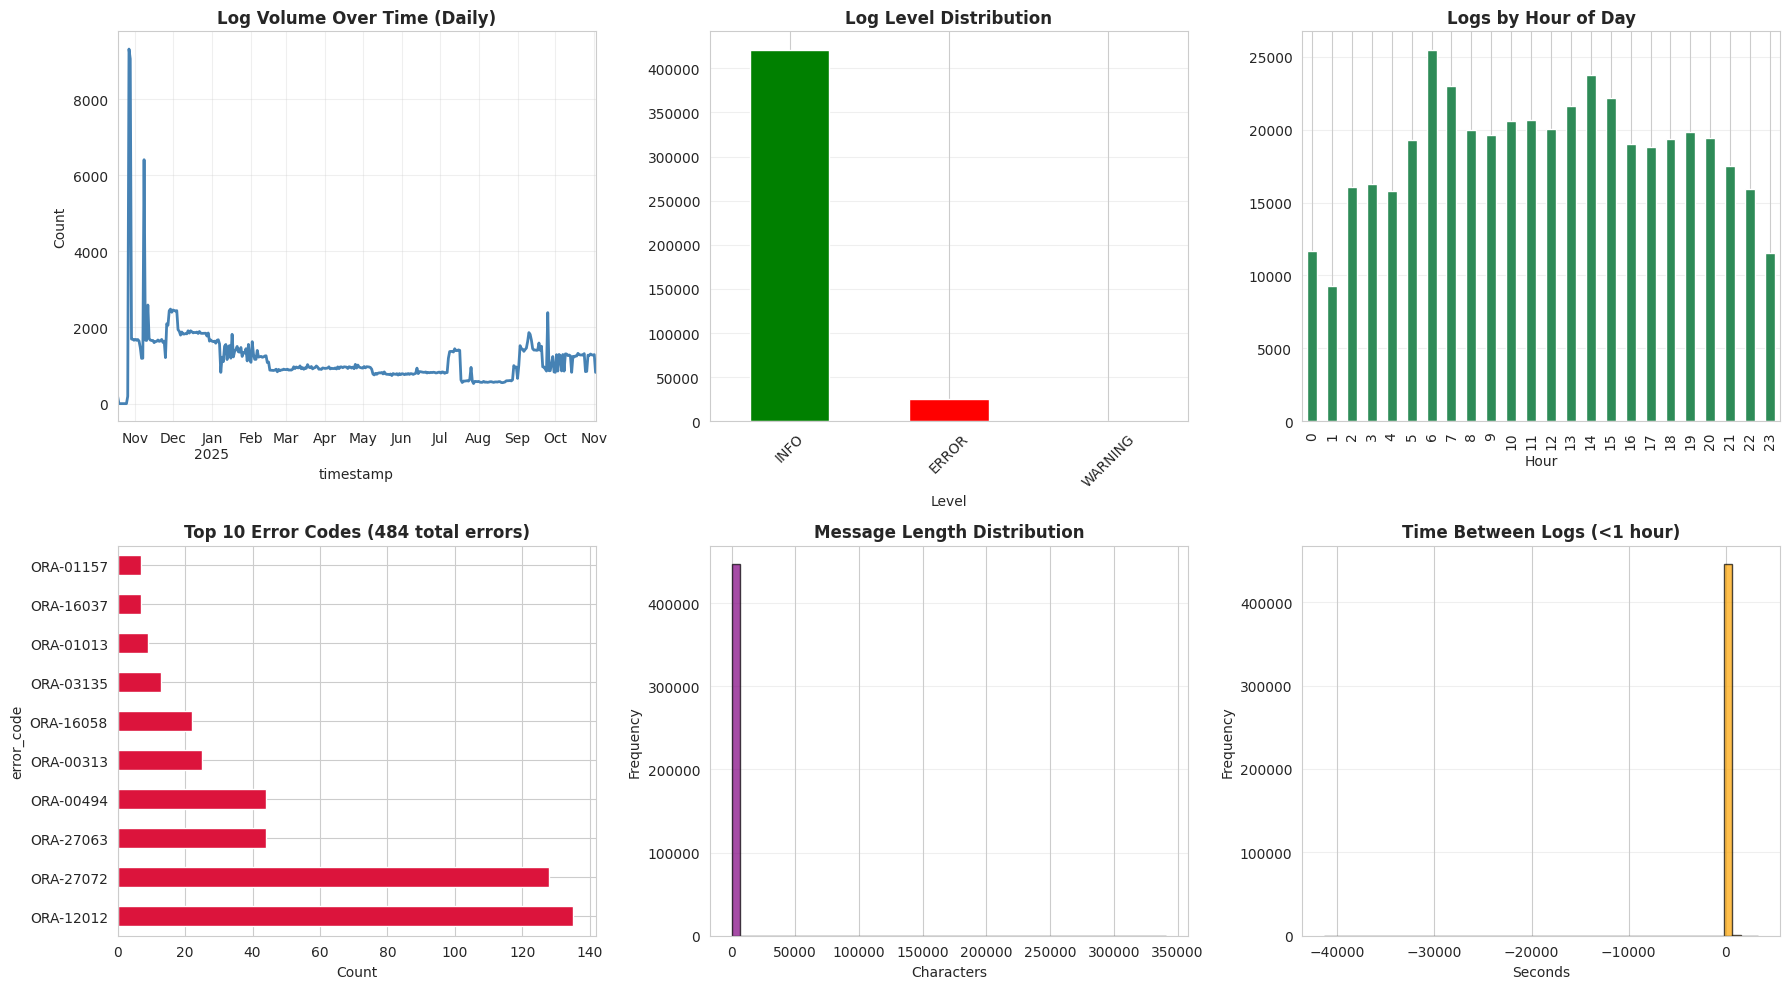


📊 Key Statistics:
Total entries: 446,678
Date range: 2024-10-18 to 2025-11-02
Duration: 380 days
Errors: 484 (0.11%)
Log levels: {'INFO': 420875, 'ERROR': 25732, 'WARNING': 71}


In [19]:
"""
Visualize Oracle log patterns
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Logs over time
df.set_index('timestamp').resample('1D')['log_level'].count().plot(ax=axes[0,0], color='steelblue', linewidth=2)
axes[0,0].set_title('Log Volume Over Time (Daily)', fontweight='bold', fontsize=12)
axes[0,0].set_ylabel('Count')
axes[0,0].grid(alpha=0.3)

# 2. Log levels
log_counts = df['log_level'].value_counts()
colors = {'INFO': 'green', 'WARNING': 'orange', 'ERROR': 'red', 'CRITICAL': 'darkred'}
log_colors = [colors.get(lvl, 'gray') for lvl in log_counts.index]
log_counts.plot(kind='bar', ax=axes[0,1], color=log_colors)
axes[0,1].set_title('Log Level Distribution', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('Level')
axes[0,1].set_xticklabels(log_counts.index, rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Hour of day
df['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[0,2], color='seagreen')
axes[0,2].set_title('Logs by Hour of Day', fontweight='bold', fontsize=12)
axes[0,2].set_xlabel('Hour')
axes[0,2].grid(axis='y', alpha=0.3)

# 4. Top error codes
if df['has_error'].sum() > 0:
    top_errors = df[df['has_error']==1]['error_code'].value_counts().head(10)
    top_errors.plot(kind='barh', ax=axes[1,0], color='crimson')
    axes[1,0].set_title(f'Top 10 Error Codes ({df["has_error"].sum():,} total errors)', fontweight='bold', fontsize=12)
    axes[1,0].set_xlabel('Count')
else:
    axes[1,0].text(0.5, 0.5, 'No errors found', ha='center', va='center', fontsize=14)
    axes[1,0].set_title('Top Error Codes', fontweight='bold', fontsize=12)

# 5. Message length distribution
axes[1,1].hist(df['message_length'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1,1].set_title('Message Length Distribution', fontweight='bold', fontsize=12)
axes[1,1].set_xlabel('Characters')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(axis='y', alpha=0.3)

# 6. Time between logs (filter to < 1 hour for visibility)
time_diff_filtered = df['time_since_last_log'][df['time_since_last_log'] < 3600]
axes[1,2].hist(time_diff_filtered, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1,2].set_title('Time Between Logs (<1 hour)', fontweight='bold', fontsize=12)
axes[1,2].set_xlabel('Seconds')
axes[1,2].set_ylabel('Frequency')
axes[1,2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/oracle_log_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved visualization: results/oracle_log_analysis.png")
plt.show()

print(f"\n📊 Key Statistics:")
print(f"Total entries: {len(df):,}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"Errors: {df['has_error'].sum():,} ({df['has_error'].mean()*100:.2f}%)")
print(f"Log levels: {df['log_level'].value_counts().to_dict()}")

In [20]:
"""
Create final feature matrix for ML models
"""

from sklearn.preprocessing import StandardScaler

print("="*60)
print("PREPARING FEATURES FOR MACHINE LEARNING")
print("="*60)
print()

# Select features for modeling
feature_cols = [
    # Time features
    'hour', 'day_of_week', 'month',
    'is_weekend', 'is_business_hours',

    # Log characteristics
    'log_severity', 'has_error',
    'message_length',

    # Pattern features
    'has_deadlock', 'has_tablespace',
    'has_checkpoint',

    # Statistical features
    'error_rate_rolling', 'message_length_rolling',
    'time_since_last_log', 'time_between_logs_rolling',
    'is_burst',

    # One-hot encoded log levels
    'level_INFO', 'level_WARNING', 'level_ERROR', 'level_CRITICAL'
]

# Filter features that exist in dataframe
feature_cols = [f for f in feature_cols if f in df.columns]

# Create feature matrix
X = df[feature_cols].copy()

# Handle any remaining NaN values
X = X.fillna(0)

print(f"✅ Feature matrix created")
print(f"   Shape: {X.shape}")
print(f"   Features: {len(feature_cols)}")
print()

# Scale numerical features
numerical_cols = [
    'hour', 'day_of_week', 'month',
    'message_length', 'error_rate_rolling',
    'message_length_rolling', 'time_since_last_log',
    'time_between_logs_rolling'
]

# Filter to existing columns
numerical_cols = [c for c in numerical_cols if c in X.columns]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print(f"✅ Scaled {len(numerical_cols)} numerical features")
print()

# Show feature list
print("📋 Complete Feature List:")
for i, feat in enumerate(feature_cols, 1):
    feat_type = "numerical" if feat in numerical_cols else "binary/categorical"
    print(f"{i:2d}. {feat:30s} [{feat_type}]")

PREPARING FEATURES FOR MACHINE LEARNING

✅ Feature matrix created
   Shape: (446678, 19)
   Features: 19

✅ Scaled 8 numerical features

📋 Complete Feature List:
 1. hour                           [numerical]
 2. day_of_week                    [numerical]
 3. month                          [numerical]
 4. is_weekend                     [binary/categorical]
 5. is_business_hours              [binary/categorical]
 6. log_severity                   [binary/categorical]
 7. has_error                      [binary/categorical]
 8. message_length                 [numerical]
 9. has_deadlock                   [binary/categorical]
10. has_tablespace                 [binary/categorical]
11. has_checkpoint                 [binary/categorical]
12. error_rate_rolling             [numerical]
13. message_length_rolling         [numerical]
14. time_since_last_log            [numerical]
15. time_between_logs_rolling      [numerical]
16. is_burst                       [binary/categorical]
17. level_INFO

In [21]:
"""
Save processed data and features
"""

import joblib
import json

print("="*60)
print("SAVING PROCESSED DATA")
print("="*60)
print()

# Save full processed dataframe
df.to_csv('data/oracle_log_processed.csv', index=False)
print(f"✅ Saved: data/oracle_log_processed.csv")
print(f"   Shape: {df.shape}")
print(f"   Size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

# Save feature matrices
X.to_csv('data/features_unscaled.csv', index=False)
print(f"✅ Saved: data/features_unscaled.csv")
print(f"   Shape: {X.shape}")
print()

X_scaled.to_csv('data/features_scaled.csv', index=False)
print(f"✅ Saved: data/features_scaled.csv")
print(f"   Shape: {X_scaled.shape}")
print()

# Save scaler for future use
joblib.dump(scaler, 'models/scaler.pkl')
print(f"✅ Saved: models/scaler.pkl")
print()

# Save feature metadata
feature_info = {
    'total_features': len(feature_cols),
    'all_features': feature_cols,
    'numerical_features': numerical_cols,
    'binary_features': [f for f in feature_cols if f not in numerical_cols],
    'dataset_info': {
        'total_logs': len(df),
        'date_range': f"{df['timestamp'].min()} to {df['timestamp'].max()}",
        'error_rate': float(df['has_error'].mean()),
        'duration_days': int((df['timestamp'].max() - df['timestamp'].min()).days)
    }
}

with open('data/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2, default=str)
print(f"✅ Saved: data/feature_info.json")
print()

print("="*60)
print("🎉 PREPROCESSING COMPLETE!")
print("="*60)
print()
print("📊 Summary:")
print(f"  • Total log entries: {len(df):,}")
print(f"  • Time span: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"  • Features created: {len(feature_cols)}")
print(f"  • Error entries: {df['has_error'].sum():,} ({df['has_error'].mean()*100:.2f}%)")
print(f"  • Data quality: No missing values")
print()


SAVING PROCESSED DATA

✅ Saved: data/oracle_log_processed.csv
   Shape: (446678, 28)
   Size: 366.46 MB

✅ Saved: data/features_unscaled.csv
   Shape: (446678, 19)

✅ Saved: data/features_scaled.csv
   Shape: (446678, 19)

✅ Saved: models/scaler.pkl

✅ Saved: data/feature_info.json

🎉 PREPROCESSING COMPLETE!

📊 Summary:
  • Total log entries: 446,678
  • Time span: 380 days
  • Features created: 19
  • Error entries: 484 (0.11%)
  • Data quality: No missing values



In [22]:
print("="*60)
print("ISOLATION FOREST - ANOMALY DETECTION")
print("="*60)
print()

# Load preprocessed data
print("Loading data...")
X_scaled = pd.read_csv('data/features_scaled.csv')
df_full = pd.read_csv('data/oracle_log_processed.csv')

print(f"✅ Loaded {len(X_scaled):,} log entries")
print(f"✅ Features: {X_scaled.shape[1]}")
print()

# Load feature info
with open('data/feature_info.json', 'r') as f:
    feature_info = json.load(f)

print("Features being used:")
for i, feat in enumerate(feature_info['all_features'], 1):
    print(f"  {i:2d}. {feat}")

ISOLATION FOREST - ANOMALY DETECTION

Loading data...
✅ Loaded 446,678 log entries
✅ Features: 19

Features being used:
   1. hour
   2. day_of_week
   3. month
   4. is_weekend
   5. is_business_hours
   6. log_severity
   7. has_error
   8. message_length
   9. has_deadlock
  10. has_tablespace
  11. has_checkpoint
  12. error_rate_rolling
  13. message_length_rolling
  14. time_since_last_log
  15. time_between_logs_rolling
  16. is_burst
  17. level_INFO
  18. level_WARNING
  19. level_ERROR


In [23]:
"""
Train Isolation Forest Model
"""

print()
print("="*60)
print("TRAINING ISOLATION FOREST")
print("="*60)
print()

# Model parameters
contamination = 0.001  # Expect ~0.1% anomalies (since you have 0.12% errors)
n_estimators = 100
random_state = 42

print("Model Configuration:")
print(f"  • n_estimators: {n_estimators}")
print(f"  • contamination: {contamination} ({contamination*100}%)")
print(f"  • random_state: {random_state}")
print()

# Initialize model
iso_forest = IsolationForest(
    n_estimators=n_estimators,
    contamination=contamination,
    random_state=random_state,
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Train model
print("Training model...")
print("(This may take 2-3 minutes for 412K samples)")
print()

iso_forest.fit(X_scaled)

print()
print("✅ Model trained successfully!")
print()

# Make predictions
print("Making predictions...")
predictions = iso_forest.predict(X_scaled)
anomaly_scores = iso_forest.score_samples(X_scaled)

# Convert predictions: -1 = anomaly, 1 = normal
# Convert to: 1 = anomaly, 0 = normal
predictions_binary = (predictions == -1).astype(int)

print("✅ Predictions complete!")
print()

# Results
n_anomalies = predictions_binary.sum()
print("="*60)
print("RESULTS")
print("="*60)
print(f"Total samples: {len(predictions_binary):,}")
print(f"Detected anomalies: {n_anomalies:,} ({n_anomalies/len(predictions_binary)*100:.2f}%)")
print(f"Normal logs: {len(predictions_binary) - n_anomalies:,}")


TRAINING ISOLATION FOREST

Model Configuration:
  • n_estimators: 100
  • contamination: 0.001 (0.1%)
  • random_state: 42

Training model...
(This may take 2-3 minutes for 412K samples)



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished



✅ Model trained successfully!

Making predictions...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


✅ Predictions complete!

RESULTS
Total samples: 446,678
Detected anomalies: 446 (0.10%)
Normal logs: 446,232


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


In [24]:
"""
Analyze Anomaly Detection Results
"""

# Add predictions to dataframe
df_full['anomaly_score'] = anomaly_scores
df_full['is_anomaly'] = predictions_binary

print()
print("="*60)
print("ANOMALY ANALYSIS")
print("="*60)
print()

# Compare anomalies with actual errors
print("📊 Anomalies vs Actual Errors:")
print(f"  Actual errors in data: {df_full['has_error'].sum():,} ({df_full['has_error'].mean()*100:.2f}%)")
print(f"  Detected anomalies: {n_anomalies:,} ({n_anomalies/len(df_full)*100:.2f}%)")
print()

# Cross-tabulation
print("Confusion Matrix (Anomalies vs Errors):")
ct = pd.crosstab(df_full['has_error'], df_full['is_anomaly'],
                  rownames=['Has Error'], colnames=['Detected as Anomaly'])
print(ct)
print()

# What percentage of detected anomalies are actual errors?
if n_anomalies > 0:
    error_overlap = df_full[(df_full['is_anomaly']==1) & (df_full['has_error']==1)].shape[0]
    print(f"📍 {error_overlap:,} detected anomalies ({error_overlap/n_anomalies*100:.2f}%) are actual errors")
    print(f"📍 {n_anomalies - error_overlap:,} detected anomalies ({(n_anomalies-error_overlap)/n_anomalies*100:.2f}%) are OTHER unusual patterns")
print()

# Check what columns we have for messages
msg_col = None
for col in ['message', 'msg', 'message_clean', 'raw_text']:
    if col in df_full.columns:
        msg_col = col
        break

# Display columns for top anomalies
display_cols = ['timestamp', 'log_level', 'has_error', 'anomaly_score']
if msg_col:
    display_cols.append(msg_col)

# Top anomalies
print("🔍 Top 10 Most Anomalous Logs (Lowest Scores = Most Anomalous):")
top_anomalies = df_full.nsmallest(10, 'anomaly_score', keep='first')
print(top_anomalies[display_cols].to_string())
print()

# Bottom anomalies (most normal)
print("✅ Top 10 Most Normal Logs (Highest Scores = Most Normal):")
most_normal = df_full.nlargest(10, 'anomaly_score', keep='first')
print(most_normal[display_cols].to_string())
print()

# Show some statistics about detected anomalies
print("📈 Anomaly Statistics:")
anomaly_data = df_full[df_full['is_anomaly']==1]
print(f"  • Anomalies with errors: {anomaly_data['has_error'].sum()} ({anomaly_data['has_error'].mean()*100:.2f}%)")
print(f"  • Anomaly log levels: {anomaly_data['log_level'].value_counts().to_dict()}")
print(f"  • Average anomaly score: {anomaly_data['anomaly_score'].mean():.4f}")
print(f"  • Min anomaly score: {anomaly_data['anomaly_score'].min():.4f}")
print(f"  • Max anomaly score: {anomaly_data['anomaly_score'].max():.4f}")


ANOMALY ANALYSIS

📊 Anomalies vs Actual Errors:
  Actual errors in data: 484 (0.11%)
  Detected anomalies: 446 (0.10%)

Confusion Matrix (Anomalies vs Errors):
Detected as Anomaly       0    1
Has Error                       
0                    445942  252
1                       290  194

📍 194 detected anomalies (43.50%) are actual errors
📍 252 detected anomalies (56.50%) are OTHER unusual patterns

🔍 Top 10 Most Anomalous Logs (Lowest Scores = Most Anomalous):
                 timestamp log_level  has_error  anomaly_score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

✅ Saved: results/isolation_forest_results.png


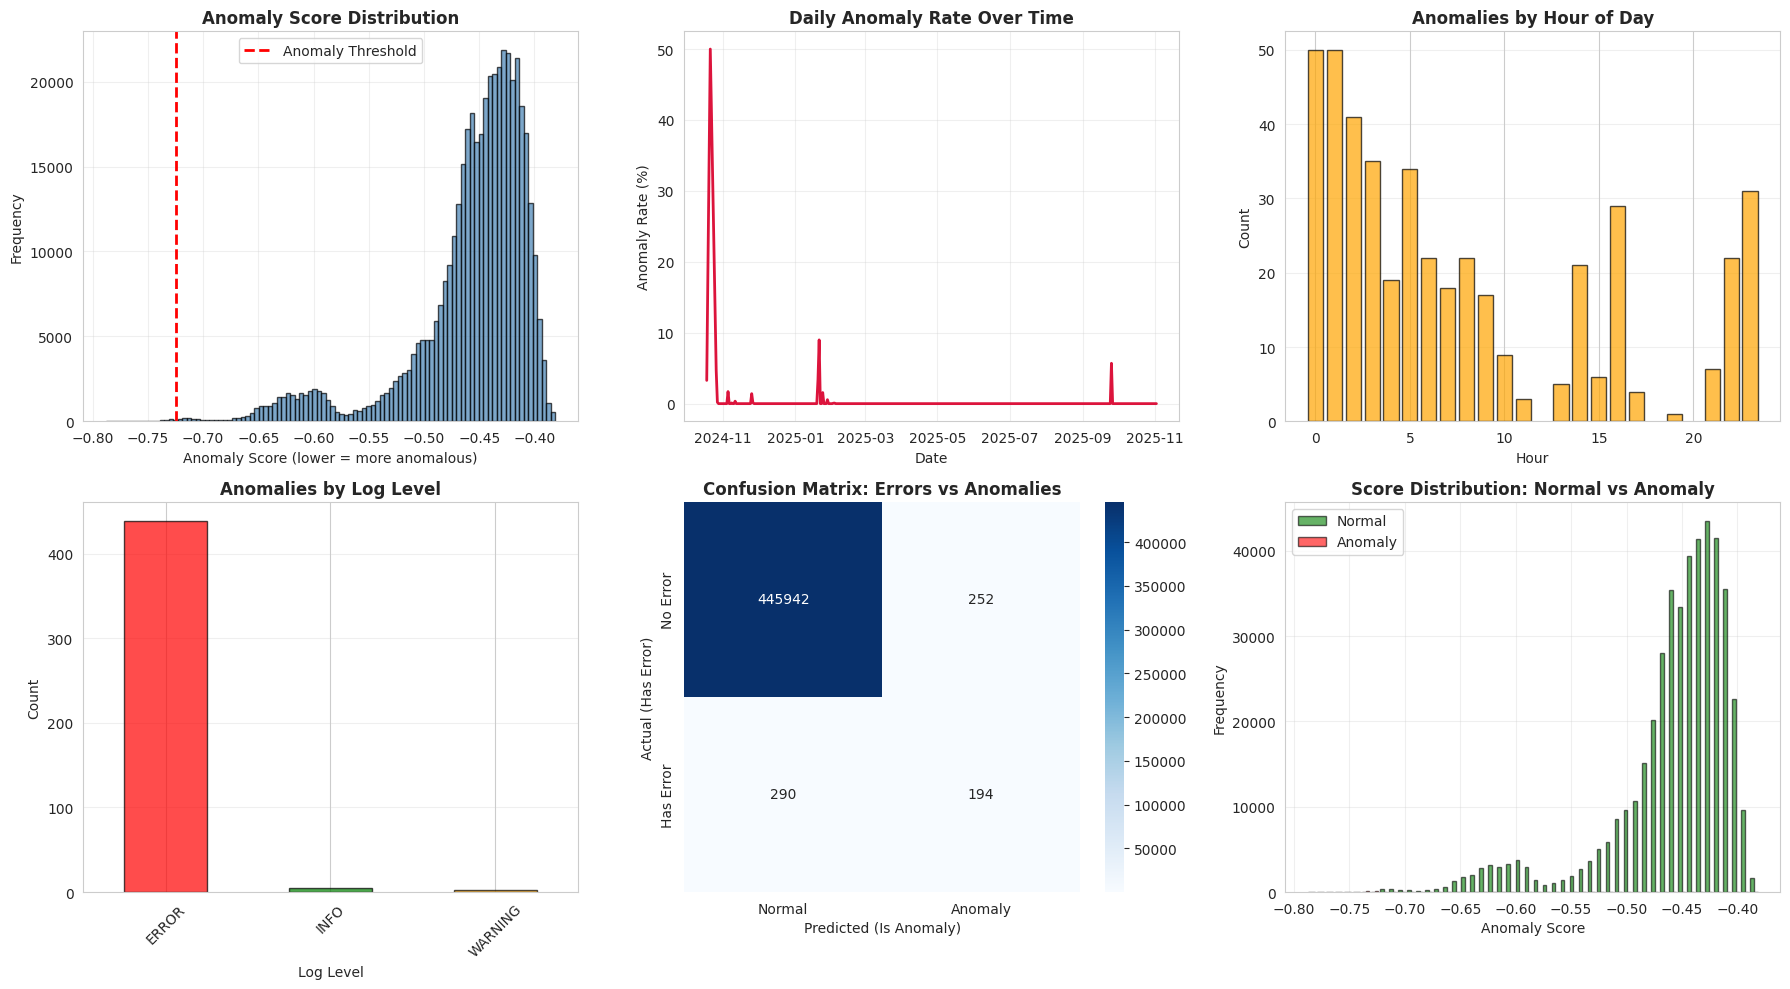

In [25]:
"""
Visualize Anomaly Detection Results
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Anomaly score distribution
axes[0, 0].hist(anomaly_scores, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=np.percentile(anomaly_scores, 0.1), color='red',
                    linestyle='--', linewidth=2, label='Anomaly Threshold')
axes[0, 0].set_title('Anomaly Score Distribution', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Anomaly Score (lower = more anomalous)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Anomalies over time
df_full['date'] = pd.to_datetime(df_full['timestamp']).dt.date
daily_anomalies = df_full[df_full['is_anomaly']==1].groupby('date').size()
daily_total = df_full.groupby('date').size()
anomaly_rate = (daily_anomalies / daily_total * 100).fillna(0)

anomaly_rate.plot(ax=axes[0, 1], color='crimson', linewidth=2)
axes[0, 1].set_title('Daily Anomaly Rate Over Time', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Anomaly Rate (%)')
axes[0, 1].grid(alpha=0.3)

# 3. Anomalies by hour
anomaly_by_hour = df_full[df_full['is_anomaly']==1]['hour'].value_counts().sort_index()
axes[0, 2].bar(anomaly_by_hour.index, anomaly_by_hour.values, color='orange', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Anomalies by Hour of Day', fontweight='bold', fontsize=12)
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Count')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Anomalies by log level
anomaly_by_level = df_full[df_full['is_anomaly']==1]['log_level'].value_counts()
colors = {'INFO': 'green', 'WARNING': 'orange', 'ERROR': 'red', 'CRITICAL': 'darkred'}
level_colors = [colors.get(lvl, 'gray') for lvl in anomaly_by_level.index]
anomaly_by_level.plot(kind='bar', ax=axes[1, 0], color=level_colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Anomalies by Log Level', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Log Level')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(anomaly_by_level.index, rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Confusion matrix (Anomalies vs Errors)
conf_matrix = confusion_matrix(df_full['has_error'], df_full['is_anomaly'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Normal', 'Anomaly'], yticklabels=['No Error', 'Has Error'])
axes[1, 1].set_title('Confusion Matrix: Errors vs Anomalies', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Actual (Has Error)')
axes[1, 1].set_xlabel('Predicted (Is Anomaly)')

# 6. Score distribution for normal vs anomaly
normal_scores = anomaly_scores[predictions_binary == 0]
anomaly_scores_detected = anomaly_scores[predictions_binary == 1]

axes[1, 2].hist([normal_scores, anomaly_scores_detected], bins=50,
                label=['Normal', 'Anomaly'], color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 2].set_title('Score Distribution: Normal vs Anomaly', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Anomaly Score')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/isolation_forest_results.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/isolation_forest_results.png")
plt.show()


FEATURE IMPORTANCE ANALYSIS

Top 10 Features Distinguishing Anomalies:
(Higher value = more important for detecting anomalies)

 1. error_rate_rolling             Difference: 9.4454
    Normal: -0.0094 | Anomaly: 9.4359

 2. message_length_rolling         Difference: 6.9294
    Normal: -0.0069 | Anomaly: 6.9225

 3. message_length                 Difference: 5.5002
    Normal: -0.0055 | Anomaly: 5.4947

 4. time_since_last_log            Difference: 3.0136
    Normal: -0.0030 | Anomaly: 3.0106

 5. log_severity                   Difference: 1.8596
    Normal: 0.1135 | Anomaly: 1.9731

 6. time_between_logs_rolling      Difference: 1.1453
    Normal: -0.0011 | Anomaly: 1.1441

 7. level_INFO                     Difference: 0.9320
    Normal: 0.9432 | Anomaly: 0.0112

 8. level_ERROR                    Difference: 0.9276
    Normal: 0.0567 | Anomaly: 0.9843

 9. hour                           Difference: 0.5973
    Normal: 0.0006 | Anomaly: -0.5967

10. day_of_week                    Di

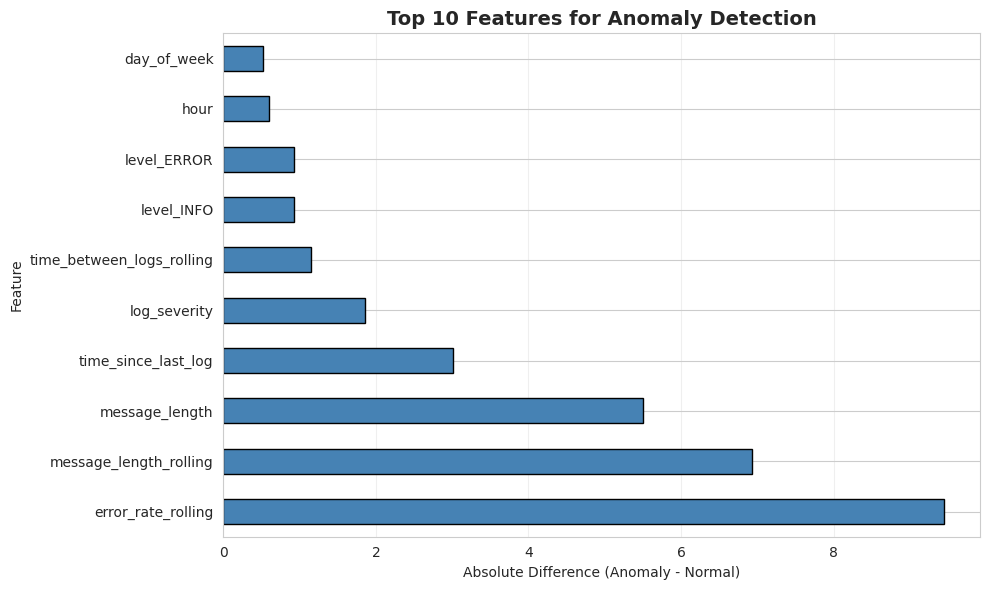

In [26]:
"""
Analyze which features contribute most to anomaly detection
"""

print()
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)
print()

# Get anomalous samples
anomalous_samples = X_scaled[predictions_binary == 1]
normal_samples = X_scaled[predictions_binary == 0]

# Calculate mean values for each group
anomaly_means = anomalous_samples.mean()
normal_means = normal_samples.mean()

# Calculate difference (which features differ most)
feature_diff = abs(anomaly_means - normal_means).sort_values(ascending=False)

print("Top 10 Features Distinguishing Anomalies:")
print("(Higher value = more important for detecting anomalies)")
print()
for i, (feat, diff) in enumerate(feature_diff.head(10).items(), 1):
    print(f"{i:2d}. {feat:30s} Difference: {diff:.4f}")
    print(f"    Normal: {normal_means[feat]:.4f} | Anomaly: {anomaly_means[feat]:.4f}")
    print()

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_diff.head(10).plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Top 10 Features for Anomaly Detection', fontweight='bold', fontsize=14)
plt.xlabel('Absolute Difference (Anomaly - Normal)')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('results/isolation_forest_feature_importance.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/isolation_forest_feature_importance.png")
plt.show()

In [27]:
"""
Save Isolation Forest Model and Results
"""

print()
print("="*60)
print("SAVING MODEL AND RESULTS")
print("="*60)
print()

# Save model
joblib.dump(iso_forest, 'models/isolation_forest.pkl')
print("✅ Saved: models/isolation_forest.pkl")

# Save predictions
df_full[['timestamp', 'is_anomaly', 'anomaly_score']].to_csv(
    'results/isolation_forest_predictions.csv', index=False
)
print("✅ Saved: results/isolation_forest_predictions.csv")

# Save detailed results
results_summary = {
    'model': 'Isolation Forest',
    'parameters': {
        'n_estimators': n_estimators,
        'contamination': contamination,
        'random_state': random_state
    },
    'results': {
        'total_samples': int(len(predictions_binary)),
        'detected_anomalies': int(n_anomalies),
        'anomaly_rate': float(n_anomalies / len(predictions_binary)),
        'actual_errors': int(df_full['has_error'].sum()),
        'errors_detected_as_anomalies': int(df_full[(df_full['is_anomaly']==1) & (df_full['has_error']==1)].shape[0])
    },
    'top_features': feature_diff.head(10).to_dict()
}

with open('results/isolation_forest_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print("✅ Saved: results/isolation_forest_summary.json")

# Save full results with predictions
df_full.to_csv('data/oracle_log_with_predictions.csv', index=False)
print("✅ Saved: data/oracle_log_with_predictions.csv")

print()
print("="*60)
print("ISOLATION FOREST COMPLETE!")
print("="*60)
print()
print(" Final Summary:")
print(f"  • Model trained on {len(X_scaled):,} samples")
print(f"  • Detected {n_anomalies:,} anomalies ({n_anomalies/len(df_full)*100:.2f}%)")
print(f"  • Top feature: {feature_diff.index[0]}")
print()



SAVING MODEL AND RESULTS

✅ Saved: models/isolation_forest.pkl
✅ Saved: results/isolation_forest_predictions.csv
✅ Saved: results/isolation_forest_summary.json
✅ Saved: data/oracle_log_with_predictions.csv

ISOLATION FOREST COMPLETE!

 Final Summary:
  • Model trained on 446,678 samples
  • Detected 446 anomalies (0.10%)
  • Top feature: error_rate_rolling



In [28]:
"""
LSTM AUTOENCODER - Deep Learning Anomaly Detection
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import joblib
import json

print("="*60)
print("LSTM AUTOENCODER - ANOMALY DETECTION")
print("="*60)
print()

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Available: {gpus[0].name}")
else:
    print("ℹ️  Using CPU")
print()

# Load data
print("Loading data...")
X_scaled = pd.read_csv('data/features_scaled.csv')
df_full = pd.read_csv('data/oracle_log_with_predictions.csv')

print(f"✅ Loaded {len(X_scaled):,} log entries")
print(f"✅ Features: {X_scaled.shape[1]}")

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

LSTM AUTOENCODER - ANOMALY DETECTION

ℹ️  Using CPU

Loading data...
✅ Loaded 446,678 log entries
✅ Features: 19


In [29]:
"""
Create Time-Windowed Sequences for LSTM
LSTM needs sequences of logs, not individual logs
"""

def create_sequences(data, sequence_length=50):
    """
    Create overlapping sequences for LSTM training

    Args:
        data: Feature matrix (numpy array or DataFrame)
        sequence_length: Number of time steps in each sequence

    Returns:
        sequences: 3D array of shape (num_sequences, sequence_length, num_features)
    """
    sequences = []

    if isinstance(data, pd.DataFrame):
        data = data.values

    # Ensure data is float32
    data = data.astype(np.float32)

    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)

    return np.array(sequences, dtype=np.float32)

print("="*60)
print("CREATING SEQUENCES")
print("="*60)
print()

# First, ensure X_scaled is clean and numeric
print("Cleaning data...")
X_scaled_clean = X_scaled.copy()

# Check for any non-numeric columns
print("Data types:")
print(X_scaled_clean.dtypes.value_counts())
print()

# Convert everything to float32
X_scaled_clean = X_scaled_clean.astype(np.float32)

# Check for NaN or infinity
print("Checking for invalid values...")
nan_count = X_scaled_clean.isna().sum().sum()
inf_count = np.isinf(X_scaled_clean.values).sum()

print(f"NaN values: {nan_count}")
print(f"Infinity values: {inf_count}")

if nan_count > 0:
    print("Filling NaN values with 0...")
    X_scaled_clean = X_scaled_clean.fillna(0)

if inf_count > 0:
    print("Replacing infinity values...")
    X_scaled_clean = X_scaled_clean.replace([np.inf, -np.inf], 0)

print("✅ Data cleaned")
print()

# Parameters
SEQUENCE_LENGTH = 50  # Use 50 consecutive logs as one sequence
print(f"Sequence length: {SEQUENCE_LENGTH} time steps")
print()

# Create sequences
print("Creating sequences (this may take 1-2 minutes)...")
X_sequences = create_sequences(X_scaled_clean, SEQUENCE_LENGTH)

print(f"✅ Created {len(X_sequences):,} sequences")
print(f"✅ Sequence shape: {X_sequences.shape}")
print(f"   - Number of sequences: {X_sequences.shape[0]:,}")
print(f"   - Time steps per sequence: {X_sequences.shape[1]}")
print(f"   - Features per time step: {X_sequences.shape[2]}")
print(f"✅ Data type: {X_sequences.dtype}")
print()

# Verify no NaN or Inf in sequences
print("Final data validation...")
print(f"   NaN in sequences: {np.isnan(X_sequences).sum()}")
print(f"   Inf in sequences: {np.isinf(X_sequences).sum()}")
print()

# Split into train/validation (use 80/20 split)
split_idx = int(0.8 * len(X_sequences))

X_train = X_sequences[:split_idx]
X_val = X_sequences[split_idx:]

print(f"📊 Data Split:")
print(f"   Training sequences: {len(X_train):,} ({len(X_train)/len(X_sequences)*100:.1f}%)")
print(f"   Validation sequences: {len(X_val):,} ({len(X_val)/len(X_sequences)*100:.1f}%)")
print()
print("✅ Ready for model training!")

CREATING SEQUENCES

Cleaning data...
Data types:
float64    8
int64      8
bool       3
Name: count, dtype: int64

Checking for invalid values...
NaN values: 0
Infinity values: 0
✅ Data cleaned

Sequence length: 50 time steps

Creating sequences (this may take 1-2 minutes)...
✅ Created 446,629 sequences
✅ Sequence shape: (446629, 50, 19)
   - Number of sequences: 446,629
   - Time steps per sequence: 50
   - Features per time step: 19
✅ Data type: float32

Final data validation...
   NaN in sequences: 0
   Inf in sequences: 0

📊 Data Split:
   Training sequences: 357,303 (80.0%)
   Validation sequences: 89,326 (20.0%)

✅ Ready for model training!


In [30]:
"""
Build LSTM Autoencoder Architecture
"""

print()
print("="*60)
print("BUILDING LSTM AUTOENCODER")
print("="*60)
print()

# Architecture parameters
ENCODING_DIM = 32  # Compressed representation size
LSTM_UNITS = 64    # Number of LSTM units

print("Model Architecture:")
print(f"  • Input: ({SEQUENCE_LENGTH}, {X_sequences.shape[2]}) - (time_steps, features)")
print(f"  • Encoder LSTM: {LSTM_UNITS} units")
print(f"  • Bottleneck: {ENCODING_DIM} dimensions")
print(f"  • Decoder LSTM: {LSTM_UNITS} units")
print(f"  • Output: ({SEQUENCE_LENGTH}, {X_sequences.shape[2]})")
print()

# Clear any previous models
tf.keras.backend.clear_session()

# Build model
model = Sequential([
    # Encoder
    LSTM(LSTM_UNITS, activation='relu',
         input_shape=(SEQUENCE_LENGTH, X_sequences.shape[2]),
         return_sequences=True,
         dtype='float32'),
    Dropout(0.2),
    LSTM(LSTM_UNITS, activation='relu', return_sequences=False),
    Dropout(0.2),

    # Bottleneck
    Dense(ENCODING_DIM, activation='relu'),

    # Decoder
    RepeatVector(SEQUENCE_LENGTH),
    LSTM(LSTM_UNITS, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(LSTM_UNITS, activation='relu', return_sequences=True),
    Dropout(0.2),

    # Output
    TimeDistributed(Dense(X_sequences.shape[2]))
])

# Compile model with explicit dtype
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("✅ Model built successfully!")
print()
print("Model Summary:")
model.summary()
print()
print(f"✅ Model dtype: float32")
print(f"✅ Input shape: {model.input_shape}")
print(f"✅ Output shape: {model.output_shape}")


BUILDING LSTM AUTOENCODER

Model Architecture:
  • Input: (50, 19) - (time_steps, features)
  • Encoder LSTM: 64 units
  • Bottleneck: 32 dimensions
  • Decoder LSTM: 64 units
  • Output: (50, 19)

✅ Model built successfully!

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 19)         │         1,235 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,699 (451.95 KB)

 Trainable params: 115,699 (451.95 KB)

 Non-trainable params: 0 (0.00 B)


✅ Model dtype: float32
✅ Input shape: (None, 50, 19)
✅ Output shape: (None, 50, 19)


In [31]:
"""
Train LSTM Autoencoder
"""

print()
print("="*60)
print("TRAINING")
print("="*60)
print()

EPOCHS = 15
BATCH_SIZE = 128

print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
print()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('models/lstm_autoencoder_best.keras', monitor='val_loss',
                    save_best_only=True, verbose=1)
]

print("Training started...")
print()

history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

print()
print("✅ Training complete!")


TRAINING

Epochs: 15, Batch size: 128

Training started...

Epoch 1/15
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 40503652352.0000 - mae: 996.7111
Epoch 1: val_loss improved from inf to 24356424.00000, saving model to models/lstm_autoencoder_best.keras
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 1092s 387ms/step - loss: 40494796800.0000 - mae: 996.5315 - val_loss: 24356424.0000 - val_mae: 245.3479
Epoch 2/15
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 2968878.5000 - mae: 27.1511
Epoch 2: val_loss improved from 24356424.00000 to 190345.70312, saving model to models/lstm_autoencoder_best.keras
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 1101s 394ms/step - loss: 2968637.5000 - mae: 27.1503 - val_loss: 190345.7031 - val_mae: 23.2769
Epoch 3/15
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 2606013.5000 - mae: 16.3049
Epoch 3: val_loss did not improve from 190345.70312
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 1077s 386ms/step - loss: 2605500.5000 - mae: 16.3027 - val_loss: 210285.6875 - val_mae: 27.2

In [32]:
"""
Detect Anomalies Using Trained LSTM
"""

print()
print("="*60)
print("DETECTING ANOMALIES")
print("="*60)
print()

# Make predictions on all sequences
print("Computing reconstruction errors...")
X_pred = model.predict(X_sequences, batch_size=128, verbose=1)

# Calculate reconstruction error (MSE) for each sequence
reconstruction_errors = np.mean(np.square(X_sequences - X_pred), axis=(1, 2))

print(f"✅ Computed {len(reconstruction_errors):,} reconstruction errors")
print()

# Determine anomaly threshold (99th percentile)
threshold = np.percentile(reconstruction_errors, 99)

print(f"📊 Reconstruction Error Statistics:")
print(f"   Mean: {reconstruction_errors.mean():.6f}")
print(f"   Std: {reconstruction_errors.std():.6f}")
print(f"   Min: {reconstruction_errors.min():.6f}")
print(f"   Max: {reconstruction_errors.max():.6f}")
print(f"   Median: {np.median(reconstruction_errors):.6f}")
print(f"   95th percentile: {np.percentile(reconstruction_errors, 95):.6f}")
print(f"   99th percentile (threshold): {threshold:.6f}")
print()

# Classify anomalies
lstm_predictions = (reconstruction_errors > threshold).astype(int)
n_anomalies_lstm = lstm_predictions.sum()

print(f"🎯 Anomaly Detection Results:")
print(f"   Total sequences: {len(lstm_predictions):,}")
print(f"   Detected anomalies: {n_anomalies_lstm:,} ({n_anomalies_lstm/len(lstm_predictions)*100:.2f}%)")
print(f"   Normal sequences: {len(lstm_predictions) - n_anomalies_lstm:,}")


DETECTING ANOMALIES

Computing reconstruction errors...
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 445s 127ms/step
✅ Computed 446,629 reconstruction errors

📊 Reconstruction Error Statistics:
   Mean: 0.456782
   Std: 9.317859
   Min: 0.033531
   Max: 919.053040
   Median: 0.196799
   95th percentile: 0.365419
   99th percentile (threshold): 2.039543

🎯 Anomaly Detection Results:
   Total sequences: 446,629
   Detected anomalies: 4,467 (1.00%)
   Normal sequences: 442,162


In [33]:
"""
Map sequence anomalies back to individual logs
"""

print()
print("="*60)
print("MAPPING ANOMALIES TO LOGS")
print("="*60)
print()

# Map back to original logs (use middle index of each sequence)
lstm_anomaly_indices = np.where(lstm_predictions == 1)[0]
log_indices_with_anomalies = lstm_anomaly_indices + (SEQUENCE_LENGTH // 2)

# Filter indices that are within dataframe bounds
valid_log_indices = log_indices_with_anomalies[log_indices_with_anomalies < len(df_full)]

# Create anomaly columns in full dataframe
df_full['lstm_anomaly'] = 0
df_full['lstm_recon_error'] = np.nan

# Mark anomalous logs
df_full.loc[valid_log_indices, 'lstm_anomaly'] = 1

# Map reconstruction errors to all logs where we have them
for i, error in enumerate(reconstruction_errors):
    log_idx = i + (SEQUENCE_LENGTH // 2)
    if log_idx < len(df_full):
        df_full.loc[log_idx, 'lstm_recon_error'] = error

print(f"✅ Mapped {len(valid_log_indices):,} anomalous sequences to logs")
print(f"✅ Total logs with LSTM predictions: {df_full['lstm_recon_error'].notna().sum():,}")


MAPPING ANOMALIES TO LOGS

✅ Mapped 4,467 anomalous sequences to logs
✅ Total logs with LSTM predictions: 446,629


In [34]:
"""
Compare LSTM with Isolation Forest Results
"""

print()
print("="*60)
print("MODEL COMPARISON: LSTM vs ISOLATION FOREST")
print("="*60)
print()

# Get logs where we have both predictions
comparison_df = df_full[df_full['lstm_recon_error'].notna()].copy()

print(f"📊 Comparing on {len(comparison_df):,} logs with both predictions:")
print()

# Isolation Forest results
iso_anomalies = comparison_df['is_anomaly'].sum()
iso_rate = iso_anomalies / len(comparison_df) * 100
print(f"Isolation Forest:")
print(f"   Detected: {iso_anomalies:,} anomalies ({iso_rate:.2f}%)")
print()

# LSTM results
lstm_anomalies = comparison_df['lstm_anomaly'].sum()
lstm_rate = lstm_anomalies / len(comparison_df) * 100
print(f"LSTM Autoencoder:")
print(f"   Detected: {lstm_anomalies:,} anomalies ({lstm_rate:.2f}%)")
print()

# Overlap analysis
both_anomaly = comparison_df[(comparison_df['is_anomaly']==1) & (comparison_df['lstm_anomaly']==1)]
only_iso = comparison_df[(comparison_df['is_anomaly']==1) & (comparison_df['lstm_anomaly']==0)]
only_lstm = comparison_df[(comparison_df['is_anomaly']==0) & (comparison_df['lstm_anomaly']==1)]
neither = comparison_df[(comparison_df['is_anomaly']==0) & (comparison_df['lstm_anomaly']==0)]

print(f"🔍 Model Agreement Analysis:")
print(f"   Both models agree (ANOMALY): {len(both_anomaly):,}")
print(f"   Only Isolation Forest: {len(only_iso):,}")
print(f"   Only LSTM: {len(only_lstm):,}")
print(f"   Both agree (NORMAL): {len(neither):,}")
print()

if len(both_anomaly) > 0:
    agreement_rate = len(both_anomaly) / max(iso_anomalies, lstm_anomalies) * 100
    print(f"   Agreement rate: {agreement_rate:.1f}%")
print()

# Compare with actual errors
print(f"📍 Comparison with Actual Errors:")
total_errors = comparison_df['has_error'].sum()
iso_found_errors = comparison_df[(comparison_df['is_anomaly']==1) & (comparison_df['has_error']==1)]
lstm_found_errors = comparison_df[(comparison_df['lstm_anomaly']==1) & (comparison_df['has_error']==1)]
both_found_errors = comparison_df[(comparison_df['is_anomaly']==1) & (comparison_df['lstm_anomaly']==1) & (comparison_df['has_error']==1)]

print(f"   Total actual errors: {total_errors:,}")
print(f"   Isolation Forest found: {len(iso_found_errors):,} ({len(iso_found_errors)/total_errors*100:.1f}%)")
print(f"   LSTM found: {len(lstm_found_errors):,} ({len(lstm_found_errors)/total_errors*100:.1f}%)")
print(f"   Both models found: {len(both_found_errors):,} ({len(both_found_errors)/total_errors*100:.1f}%)")


MODEL COMPARISON: LSTM vs ISOLATION FOREST

📊 Comparing on 446,629 logs with both predictions:

Isolation Forest:
   Detected: 446 anomalies (0.10%)

LSTM Autoencoder:
   Detected: 4,467 anomalies (1.00%)

🔍 Model Agreement Analysis:
   Both models agree (ANOMALY): 434
   Only Isolation Forest: 12
   Only LSTM: 4,033
   Both agree (NORMAL): 442,150

   Agreement rate: 9.7%

📍 Comparison with Actual Errors:
   Total actual errors: 484
   Isolation Forest found: 194 (40.1%)
   LSTM found: 263 (54.3%)
   Both models found: 190 (39.3%)


✅ Saved: results/lstm_autoencoder_results.png


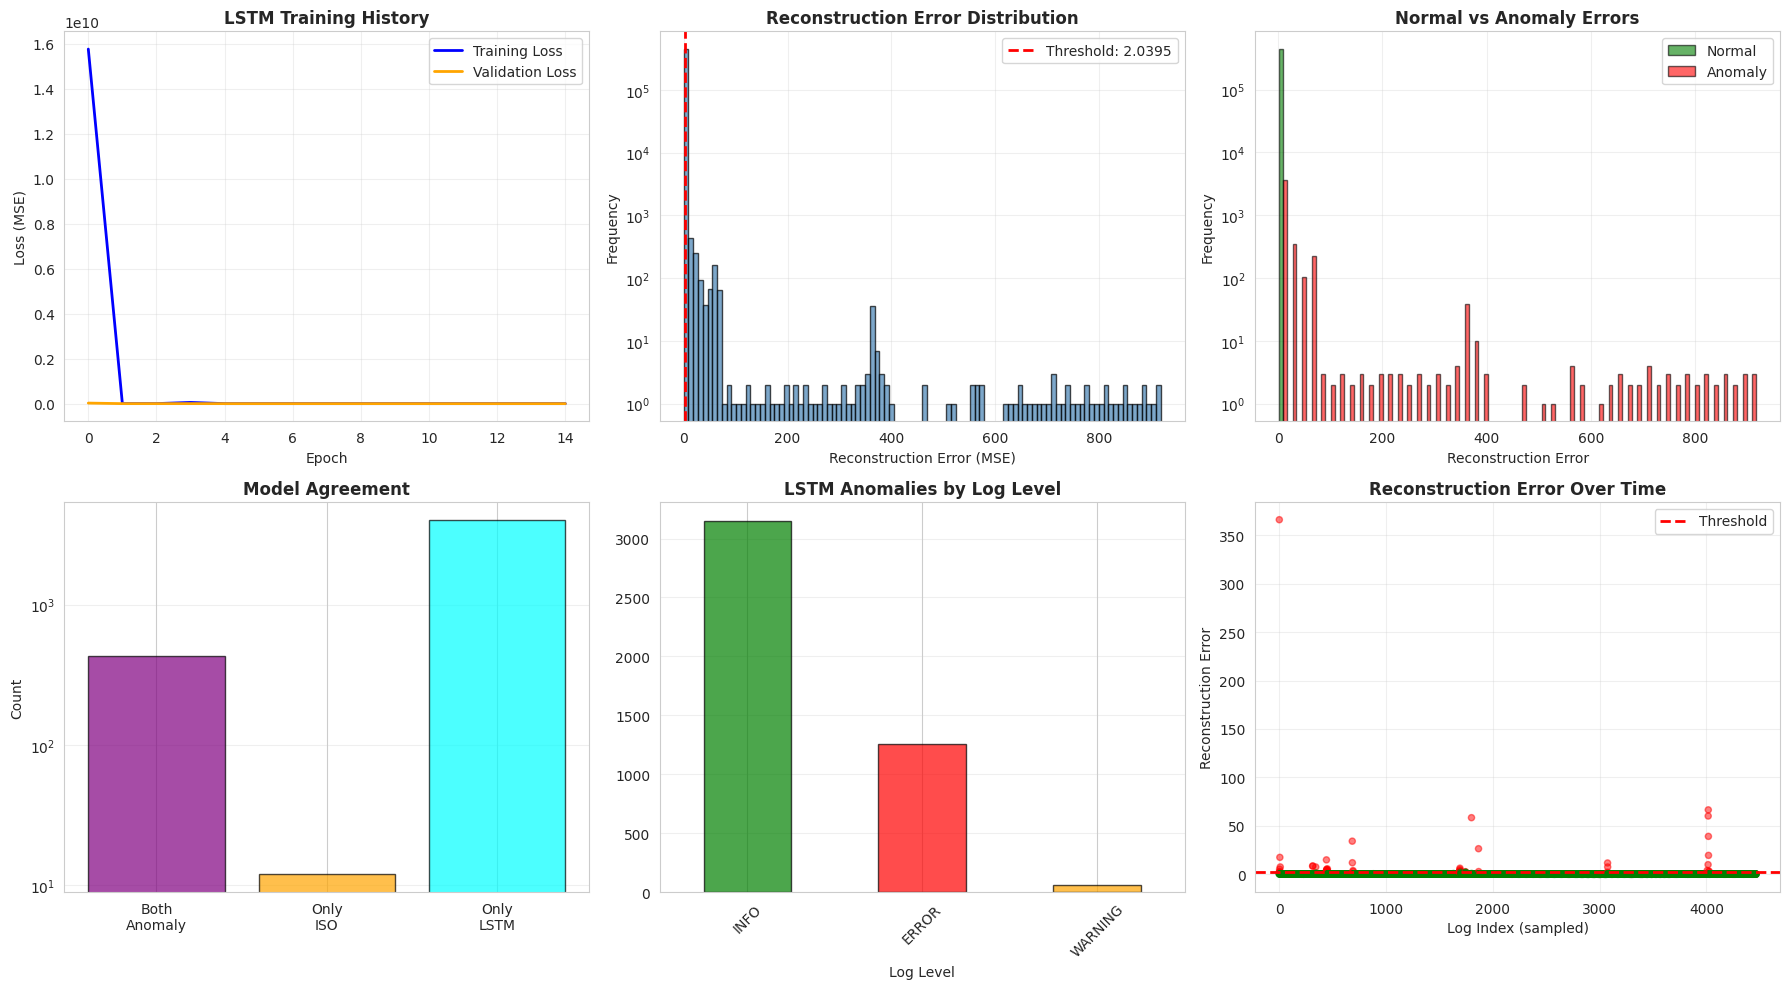

In [35]:
"""
Visualize LSTM Autoencoder Results
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Training history
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('LSTM Training History', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Reconstruction error distribution
axes[0, 1].hist(reconstruction_errors, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Threshold: {threshold:.4f}')
axes[0, 1].set_title('Reconstruction Error Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Reconstruction Error (MSE)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Normal vs Anomaly error distribution
normal_errors = reconstruction_errors[lstm_predictions == 0]
anomaly_errors = reconstruction_errors[lstm_predictions == 1]
axes[0, 2].hist([normal_errors, anomaly_errors], bins=50,
                label=['Normal', 'Anomaly'], color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[0, 2].set_title('Normal vs Anomaly Errors', fontweight='bold', fontsize=12)
axes[0, 2].set_xlabel('Reconstruction Error')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_yscale('log')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Model agreement comparison
agreement_data = {
    'Both\nAnomaly': len(both_anomaly),
    'Only\nISO': len(only_iso),
    'Only\nLSTM': len(only_lstm)
}
colors_agree = ['purple', 'orange', 'cyan']
axes[1, 0].bar(agreement_data.keys(), agreement_data.values(),
               color=colors_agree, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Model Agreement', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. LSTM anomalies by log level
lstm_anomaly_df = comparison_df[comparison_df['lstm_anomaly']==1]
if len(lstm_anomaly_df) > 0:
    level_counts = lstm_anomaly_df['log_level'].value_counts()
    colors_level = {'INFO': 'green', 'WARNING': 'orange', 'ERROR': 'red', 'CRITICAL': 'darkred'}
    level_colors = [colors_level.get(lvl, 'gray') for lvl in level_counts.index]
    level_counts.plot(kind='bar', ax=axes[1, 1], color=level_colors, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('LSTM Anomalies by Log Level', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Log Level')
    axes[1, 1].set_xticklabels(level_counts.index, rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Reconstruction error timeline (sampled for visibility)
sample_df = comparison_df.iloc[::100]  # Sample every 100th
colors_scatter = ['green' if x==0 else 'red' for x in sample_df['lstm_anomaly']]
axes[1, 2].scatter(range(len(sample_df)), sample_df['lstm_recon_error'],
                   c=colors_scatter, alpha=0.5, s=20)
axes[1, 2].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[1, 2].set_title('Reconstruction Error Over Time', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Log Index (sampled)')
axes[1, 2].set_ylabel('Reconstruction Error')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/lstm_autoencoder_results.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/lstm_autoencoder_results.png")
plt.show()

In [36]:
"""
Save LSTM Model and Results
"""

print()
print("="*60)
print("SAVING LSTM MODEL AND RESULTS")
print("="*60)
print()

# Save final model (already saved best during training)
model.save('models/lstm_autoencoder_final.keras')
print("✅ Saved: models/lstm_autoencoder_final.keras")

# Save updated dataframe with LSTM predictions
df_full.to_csv('data/oracle_log_with_all_predictions.csv', index=False)
print("✅ Saved: data/oracle_log_with_all_predictions.csv")

# Save LSTM predictions separately
lstm_results = pd.DataFrame({
    'log_index': range(len(df_full)),
    'lstm_anomaly': df_full['lstm_anomaly'],
    'lstm_recon_error': df_full['lstm_recon_error']
})
lstm_results.to_csv('results/lstm_predictions.csv', index=False)
print("✅ Saved: results/lstm_predictions.csv")

# Save summary
lstm_summary = {
    'model': 'LSTM Autoencoder',
    'architecture': {
        'sequence_length': int(SEQUENCE_LENGTH),
        'encoding_dim': int(ENCODING_DIM),
        'lstm_units': int(LSTM_UNITS),
        'input_features': int(X_sequences.shape[2])
    },
    'training': {
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'best_val_loss': float(min(history.history['val_loss']))
    },
    'results': {
        'total_sequences': int(len(lstm_predictions)),
        'detected_anomalies': int(n_anomalies_lstm),
        'anomaly_rate': float(n_anomalies_lstm / len(lstm_predictions)),
        'threshold': float(threshold),
        'logs_analyzed': int(df_full['lstm_recon_error'].notna().sum()),
        'comparison_with_isolation_forest': {
            'both_agree': int(len(both_anomaly)),
            'only_isolation_forest': int(len(only_iso)),
            'only_lstm': int(len(only_lstm))
        },
        'error_detection': {
            'lstm_found_errors': int(len(lstm_found_errors)),
            'total_errors': int(total_errors),
            'detection_rate': float(len(lstm_found_errors) / total_errors * 100) if total_errors > 0 else 0
        }
    }
}

with open('results/lstm_autoencoder_summary.json', 'w') as f:
    json.dump(lstm_summary, f, indent=2)
print("✅ Saved: results/lstm_autoencoder_summary.json")

print()
print("="*60)
print("LSTM AUTOENCODER COMPLETE!")
print("="*60)
print()
print(" Final Summary:")
print(f"  • Training epochs: {len(history.history['loss'])}")
print(f"  • Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"  • Sequences analyzed: {len(lstm_predictions):,}")
print(f"  • Anomalies detected: {n_anomalies_lstm:,} ({n_anomalies_lstm/len(lstm_predictions)*100:.2f}%)")
print(f"  • Logs with predictions: {df_full['lstm_recon_error'].notna().sum():,}")
print(f"  • Agreement with Isolation Forest: {len(both_anomaly):,} logs")
print(f"  • Errors found: {len(lstm_found_errors):,}/{total_errors} ({len(lstm_found_errors)/total_errors*100:.1f}%)")
print()
print("✅ Model saved to Google Drive - No need to retrain!")
print()



SAVING LSTM MODEL AND RESULTS

✅ Saved: models/lstm_autoencoder_final.keras
✅ Saved: data/oracle_log_with_all_predictions.csv
✅ Saved: results/lstm_predictions.csv
✅ Saved: results/lstm_autoencoder_summary.json

LSTM AUTOENCODER COMPLETE!

 Final Summary:
  • Training epochs: 15
  • Best validation loss: 0.419296
  • Sequences analyzed: 446,629
  • Anomalies detected: 4,467 (1.00%)
  • Logs with predictions: 446,629
  • Agreement with Isolation Forest: 434 logs
  • Errors found: 263/484 (54.3%)

✅ Model saved to Google Drive - No need to retrain!



In [37]:
"""
ONE-CLASS SVM - Anomaly Detection
Classic machine learning approach for anomaly detection
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json
from datetime import datetime

print("="*60)
print("ONE-CLASS SVM - ANOMALY DETECTION")
print("="*60)
print()

# Load data
print("Loading data...")
X_scaled = pd.read_csv('data/features_scaled.csv')
df_full = pd.read_csv('data/oracle_log_with_all_predictions.csv')

print(f"✅ Loaded {len(X_scaled):,} log entries")
print(f"✅ Features: {X_scaled.shape[1]}")
print()

# Load feature info
with open('data/feature_info.json', 'r') as f:
    feature_info = json.load(f)

print("Using features:")
for i, feat in enumerate(feature_info['all_features'], 1):
    print(f"  {i:2d}. {feat}")

ONE-CLASS SVM - ANOMALY DETECTION

Loading data...
✅ Loaded 446,678 log entries
✅ Features: 19

Using features:
   1. hour
   2. day_of_week
   3. month
   4. is_weekend
   5. is_business_hours
   6. log_severity
   7. has_error
   8. message_length
   9. has_deadlock
  10. has_tablespace
  11. has_checkpoint
  12. error_rate_rolling
  13. message_length_rolling
  14. time_since_last_log
  15. time_between_logs_rolling
  16. is_burst
  17. level_INFO
  18. level_WARNING
  19. level_ERROR


In [38]:
"""
Train One-Class SVM Model
"""

print()
print("="*60)
print("TRAINING ONE-CLASS SVM")
print("="*60)
print()

# Model parameters
nu = 0.001  # Expected proportion of outliers (0.1%)
kernel = 'rbf'  # Radial Basis Function kernel
gamma = 'scale'  # Kernel coefficient

print("Model Configuration:")
print(f"  • Kernel: {kernel}")
print(f"  • Nu (outlier fraction): {nu} ({nu*100}%)")
print(f"  • Gamma: {gamma}")
print()

# Initialize model
print("Initializing One-Class SVM...")
svm_model = OneClassSVM(
    kernel=kernel,
    nu=nu,
    gamma=gamma,
    verbose=True
)

# Train model
print()
print("Training model...")
print("(This will take 1-2 minutes for 412K samples)")
print()

start_time = datetime.now()
svm_model.fit(X_scaled)
end_time = datetime.now()

training_time = (end_time - start_time).total_seconds()

print()
print(f"✅ Model trained successfully!")
print(f"⏱️  Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print()

# Make predictions
print("Making predictions...")
svm_predictions = svm_model.predict(X_scaled)
svm_scores = svm_model.score_samples(X_scaled)

# Convert predictions: -1 = anomaly, 1 = normal
# Convert to: 1 = anomaly, 0 = normal
svm_predictions_binary = (svm_predictions == -1).astype(int)

print("✅ Predictions complete!")


TRAINING ONE-CLASS SVM

Model Configuration:
  • Kernel: rbf
  • Nu (outlier fraction): 0.001 (0.1%)
  • Gamma: scale

Initializing One-Class SVM...

Training model...
(This will take 1-2 minutes for 412K samples)

[LibSVM]
✅ Model trained successfully!
⏱️  Training time: 42.6 seconds (0.7 minutes)

Making predictions...
✅ Predictions complete!


In [39]:
"""
Analyze One-Class SVM Results
"""

print()
print("="*60)
print("ONE-CLASS SVM RESULTS")
print("="*60)
print()

# Count anomalies
n_anomalies_svm = svm_predictions_binary.sum()

print(f"📊 Detection Results:")
print(f"   Total samples: {len(svm_predictions_binary):,}")
print(f"   Detected anomalies: {n_anomalies_svm:,} ({n_anomalies_svm/len(svm_predictions_binary)*100:.2f}%)")
print(f"   Normal samples: {len(svm_predictions_binary) - n_anomalies_svm:,}")
print()

# Add predictions to dataframe
df_full['svm_anomaly'] = svm_predictions_binary
df_full['svm_score'] = svm_scores

# Score statistics
print(f"📈 Decision Score Statistics:")
print(f"   Mean: {svm_scores.mean():.6f}")
print(f"   Std: {svm_scores.std():.6f}")
print(f"   Min (most anomalous): {svm_scores.min():.6f}")
print(f"   Max (most normal): {svm_scores.max():.6f}")
print(f"   Median: {np.median(svm_scores):.6f}")
print()

# Compare with actual errors
print("📍 Comparison with Actual Errors:")
svm_found_errors = df_full[(df_full['svm_anomaly']==1) & (df_full['has_error']==1)]
total_errors = df_full['has_error'].sum()

print(f"   Total errors in data: {total_errors:,}")
print(f"   SVM detected errors: {len(svm_found_errors):,} ({len(svm_found_errors)/total_errors*100:.1f}%)")
print(f"   Other anomalies found: {n_anomalies_svm - len(svm_found_errors):,}")
print()

# By log level
print("🔍 SVM Anomalies by Log Level:")
svm_anomaly_df = df_full[df_full['svm_anomaly']==1]
level_dist = svm_anomaly_df['log_level'].value_counts()
for level, count in level_dist.items():
    print(f"   {level}: {count:,} ({count/len(svm_anomaly_df)*100:.1f}%)")


ONE-CLASS SVM RESULTS

📊 Detection Results:
   Total samples: 446,678
   Detected anomalies: 464 (0.10%)
   Normal samples: 446,214

📈 Decision Score Statistics:
   Mean: 11.530849
   Std: 1.026069
   Min (most anomalous): 1.000000
   Max (most normal): 15.313055
   Median: 11.507257

📍 Comparison with Actual Errors:
   Total errors in data: 484
   SVM detected errors: 108 (22.3%)
   Other anomalies found: 356

🔍 SVM Anomalies by Log Level:
   INFO: 235 (50.6%)
   ERROR: 202 (43.5%)


In [40]:
"""
Compare All Three Models: Isolation Forest, LSTM, One-Class SVM
"""

print()
print("="*60)
print("COMPARING ALL THREE MODELS")
print("="*60)
print()

# Get subset with all predictions
all_predictions_df = df_full[df_full['lstm_recon_error'].notna()].copy()

print(f"📊 Comparing on {len(all_predictions_df):,} logs with all predictions:")
print()

# Count anomalies for each model
iso_count = all_predictions_df['is_anomaly'].sum()
lstm_count = all_predictions_df['lstm_anomaly'].sum()
svm_count = all_predictions_df['svm_anomaly'].sum()

print("Individual Model Results:")
print(f"  1. Isolation Forest: {iso_count:,} anomalies ({iso_count/len(all_predictions_df)*100:.2f}%)")
print(f"  2. LSTM Autoencoder: {lstm_count:,} anomalies ({lstm_count/len(all_predictions_df)*100:.2f}%)")
print(f"  3. One-Class SVM:    {svm_count:,} anomalies ({svm_count/len(all_predictions_df)*100:.2f}%)")
print()

# Voting - anomaly if at least 2 models agree
all_predictions_df['vote_count'] = (
    all_predictions_df['is_anomaly'] +
    all_predictions_df['lstm_anomaly'] +
    all_predictions_df['svm_anomaly']
)
all_predictions_df['ensemble_anomaly'] = (all_predictions_df['vote_count'] >= 2).astype(int)

ensemble_count = all_predictions_df['ensemble_anomaly'].sum()

print(f"🗳️  Ensemble (2+ models agree):")
print(f"   Detected: {ensemble_count:,} anomalies ({ensemble_count/len(all_predictions_df)*100:.2f}%)")
print()

# Agreement analysis
print("🤝 Model Agreement Breakdown:")
print()

# All three agree
all_three = all_predictions_df[
    (all_predictions_df['is_anomaly']==1) &
    (all_predictions_df['lstm_anomaly']==1) &
    (all_predictions_df['svm_anomaly']==1)
]
print(f"   All 3 models agree (ANOMALY): {len(all_three):,}")

# Two models agree
iso_lstm = all_predictions_df[
    (all_predictions_df['is_anomaly']==1) &
    (all_predictions_df['lstm_anomaly']==1) &
    (all_predictions_df['svm_anomaly']==0)
]
iso_svm = all_predictions_df[
    (all_predictions_df['is_anomaly']==1) &
    (all_predictions_df['lstm_anomaly']==0) &
    (all_predictions_df['svm_anomaly']==1)
]
lstm_svm = all_predictions_df[
    (all_predictions_df['is_anomaly']==0) &
    (all_predictions_df['lstm_anomaly']==1) &
    (all_predictions_df['svm_anomaly']==1)
]

print(f"   ISO + LSTM only: {len(iso_lstm):,}")
print(f"   ISO + SVM only: {len(iso_svm):,}")
print(f"   LSTM + SVM only: {len(lstm_svm):,}")
print()

# Only one model
only_iso = all_predictions_df[
    (all_predictions_df['is_anomaly']==1) &
    (all_predictions_df['lstm_anomaly']==0) &
    (all_predictions_df['svm_anomaly']==0)
]
only_lstm = all_predictions_df[
    (all_predictions_df['is_anomaly']==0) &
    (all_predictions_df['lstm_anomaly']==1) &
    (all_predictions_df['svm_anomaly']==0)
]
only_svm = all_predictions_df[
    (all_predictions_df['is_anomaly']==0) &
    (all_predictions_df['lstm_anomaly']==0) &
    (all_predictions_df['svm_anomaly']==1)
]

print(f"   Only Isolation Forest: {len(only_iso):,}")
print(f"   Only LSTM: {len(only_lstm):,}")
print(f"   Only SVM: {len(only_svm):,}")
print()

# Error detection comparison
print("📍 Error Detection Performance:")
errors_df = all_predictions_df[all_predictions_df['has_error']==1]
if len(errors_df) > 0:
    iso_errors = errors_df['is_anomaly'].sum()
    lstm_errors = errors_df['lstm_anomaly'].sum()
    svm_errors = errors_df['svm_anomaly'].sum()
    ensemble_errors = errors_df['ensemble_anomaly'].sum()

    print(f"   Total errors: {len(errors_df):,}")
    print(f"   Isolation Forest found: {iso_errors:,} ({iso_errors/len(errors_df)*100:.1f}%)")
    print(f"   LSTM found: {lstm_errors:,} ({lstm_errors/len(errors_df)*100:.1f}%)")
    print(f"   SVM found: {svm_errors:,} ({svm_errors/len(errors_df)*100:.1f}%)")
    print(f"   Ensemble found: {ensemble_errors:,} ({ensemble_errors/len(errors_df)*100:.1f}%)")


COMPARING ALL THREE MODELS

📊 Comparing on 446,629 logs with all predictions:

Individual Model Results:
  1. Isolation Forest: 446 anomalies (0.10%)
  2. LSTM Autoencoder: 4,467 anomalies (1.00%)
  3. One-Class SVM:    457 anomalies (0.10%)

🗳️  Ensemble (2+ models agree):
   Detected: 692 anomalies (0.15%)

🤝 Model Agreement Breakdown:

   All 3 models agree (ANOMALY): 123
   ISO + LSTM only: 311
   ISO + SVM only: 7
   LSTM + SVM only: 251

   Only Isolation Forest: 5
   Only LSTM: 3,782
   Only SVM: 76

📍 Error Detection Performance:
   Total errors: 484
   Isolation Forest found: 194 (40.1%)
   LSTM found: 263 (54.3%)
   SVM found: 108 (22.3%)
   Ensemble found: 208 (43.0%)


✅ Saved: results/all_models_comparison.png


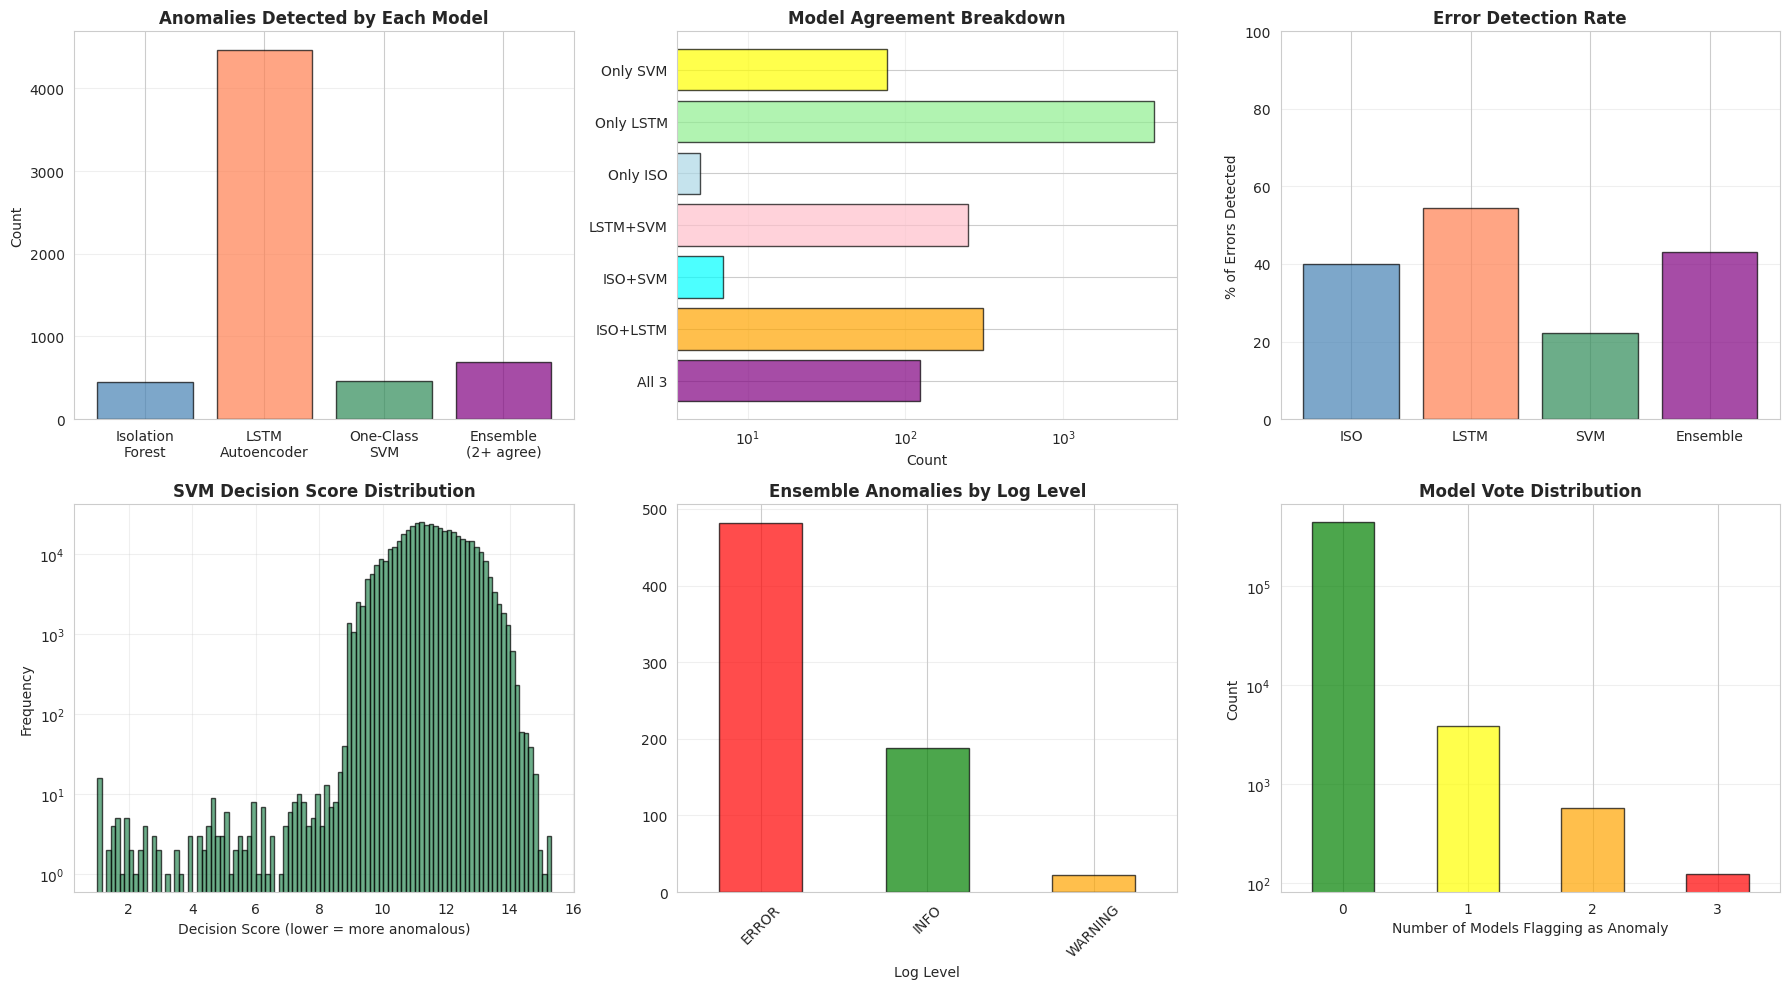

In [41]:
"""
Comprehensive Visualization of All Models
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Model comparison bar chart
model_counts = {
    'Isolation\nForest': iso_count,
    'LSTM\nAutoencoder': lstm_count,
    'One-Class\nSVM': svm_count,
    'Ensemble\n(2+ agree)': ensemble_count
}
colors_models = ['steelblue', 'coral', 'seagreen', 'purple']
axes[0, 0].bar(model_counts.keys(), model_counts.values(),
               color=colors_models, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Anomalies Detected by Each Model', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Agreement Venn-style
agreement_data = {
    'All 3': len(all_three),
    'ISO+LSTM': len(iso_lstm),
    'ISO+SVM': len(iso_svm),
    'LSTM+SVM': len(lstm_svm),
    'Only ISO': len(only_iso),
    'Only LSTM': len(only_lstm),
    'Only SVM': len(only_svm)
}
colors_agreement = ['purple', 'orange', 'cyan', 'pink', 'lightblue', 'lightgreen', 'yellow']
axes[0, 1].barh(list(agreement_data.keys()), list(agreement_data.values()),
                color=colors_agreement, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Model Agreement Breakdown', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Error detection comparison
if len(errors_df) > 0:
    error_detection = {
        'ISO': iso_errors/len(errors_df)*100,
        'LSTM': lstm_errors/len(errors_df)*100,
        'SVM': svm_errors/len(errors_df)*100,
        'Ensemble': ensemble_errors/len(errors_df)*100
    }
    axes[0, 2].bar(error_detection.keys(), error_detection.values(),
                   color=['steelblue', 'coral', 'seagreen', 'purple'],
                   alpha=0.7, edgecolor='black')
    axes[0, 2].set_title('Error Detection Rate', fontweight='bold', fontsize=12)
    axes[0, 2].set_ylabel('% of Errors Detected')
    axes[0, 2].set_ylim(0, 100)
    axes[0, 2].grid(axis='y', alpha=0.3)

# 4. SVM score distribution
axes[1, 0].hist(svm_scores, bins=100, color='seagreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('SVM Decision Score Distribution', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Decision Score (lower = more anomalous)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# 5. Ensemble anomalies by log level
ensemble_anomaly_df = all_predictions_df[all_predictions_df['ensemble_anomaly']==1]
if len(ensemble_anomaly_df) > 0:
    ensemble_levels = ensemble_anomaly_df['log_level'].value_counts()
    colors_level = {'INFO': 'green', 'WARNING': 'orange', 'ERROR': 'red', 'CRITICAL': 'darkred'}
    level_colors = [colors_level.get(lvl, 'gray') for lvl in ensemble_levels.index]
    ensemble_levels.plot(kind='bar', ax=axes[1, 1], color=level_colors,
                         alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Ensemble Anomalies by Log Level', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Log Level')
    axes[1, 1].set_xticklabels(ensemble_levels.index, rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Vote distribution
vote_dist = all_predictions_df['vote_count'].value_counts().sort_index()
colors_vote = ['green', 'yellow', 'orange', 'red']
vote_dist.plot(kind='bar', ax=axes[1, 2], color=colors_vote,
               alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Model Vote Distribution', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Number of Models Flagging as Anomaly')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_xticklabels(['0', '1', '2', '3'], rotation=0)
axes[1, 2].set_yscale('log')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/all_models_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/all_models_comparison.png")
plt.show()

In [42]:
"""
Save One-Class SVM and Create Final Report
"""

print()
print("="*60)
print("SAVING FINAL RESULTS")
print("="*60)
print()

# Save SVM model
joblib.dump(svm_model, 'models/one_class_svm.pkl')
print("✅ Saved: models/one_class_svm.pkl")

# Save complete dataframe with all predictions
df_full.to_csv('data/oracle_log_final_all_models.csv', index=False)
print("✅ Saved: data/oracle_log_final_all_models.csv")

# Save ensemble predictions
all_predictions_df.to_csv('results/ensemble_predictions.csv', index=False)
print("✅ Saved: results/ensemble_predictions.csv")

# Create comprehensive summary
final_summary = {
    'project': 'Oracle Database Log Anomaly Detection',
    'student': 'Yash Raj Bista (240224)',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'total_logs': int(len(df_full)),
        'date_range': f"{df_full['timestamp'].min()} to {df_full['timestamp'].max()}",
        'duration_days': int((pd.to_datetime(df_full['timestamp'].max()) -
                             pd.to_datetime(df_full['timestamp'].min())).days),
        'features_used': len(feature_info['all_features']),
        'actual_errors': int(df_full['has_error'].sum())
    },
    'models': {
        'isolation_forest': {
            'anomalies_detected': int(iso_count),
            'detection_rate': float(iso_count / len(all_predictions_df) * 100),
            'errors_found': int(iso_errors) if len(errors_df) > 0 else 0,
            'error_detection_rate': float(iso_errors / len(errors_df) * 100) if len(errors_df) > 0 else 0
        },
        'lstm_autoencoder': {
            'anomalies_detected': int(lstm_count),
            'detection_rate': float(lstm_count / len(all_predictions_df) * 100),
            'errors_found': int(lstm_errors) if len(errors_df) > 0 else 0,
            'error_detection_rate': float(lstm_errors / len(errors_df) * 100) if len(errors_df) > 0 else 0
        },
        'one_class_svm': {
            'anomalies_detected': int(svm_count),
            'detection_rate': float(svm_count / len(all_predictions_df) * 100),
            'errors_found': int(svm_errors) if len(errors_df) > 0 else 0,
            'error_detection_rate': float(svm_errors / len(errors_df) * 100) if len(errors_df) > 0 else 0,
            'training_time_seconds': float(training_time)
        },
        'ensemble': {
            'anomalies_detected': int(ensemble_count),
            'detection_rate': float(ensemble_count / len(all_predictions_df) * 100),
            'errors_found': int(ensemble_errors) if len(errors_df) > 0 else 0,
            'error_detection_rate': float(ensemble_errors / len(errors_df) * 100) if len(errors_df) > 0 else 0
        }
    },
    'agreement': {
        'all_three_models': int(len(all_three)),
        'iso_and_lstm': int(len(iso_lstm)),
        'iso_and_svm': int(len(iso_svm)),
        'lstm_and_svm': int(len(lstm_svm)),
        'only_isolation_forest': int(len(only_iso)),
        'only_lstm': int(len(only_lstm)),
        'only_svm': int(len(only_svm))
    }
}

with open('results/final_summary_all_models.json', 'w') as f:
    json.dump(final_summary, f, indent=2)
print("✅ Saved: results/final_summary_all_models.json")

print()
print("="*60)
print("🎉🎉🎉 ALL MODELS COMPLETE! 🎉🎉🎉")
print("="*60)
print()
print("📊 FINAL PROJECT SUMMARY")
print("="*60)
print()
print(f"Dataset: {len(df_full):,} Oracle log entries")
print(f"Duration: {(pd.to_datetime(df_full['timestamp'].max()) - pd.to_datetime(df_full['timestamp'].min())).days} days")
print(f"Features: {len(feature_info['all_features'])}")
print()
print("Model Performance:")
print(f"  1️⃣  Isolation Forest:  {iso_count:,} anomalies | {iso_errors}/{len(errors_df)} errors")
print(f"  2️⃣  LSTM Autoencoder:  {lstm_count:,} anomalies | {lstm_errors}/{len(errors_df)} errors")
print(f"  3️⃣  One-Class SVM:     {svm_count:,} anomalies | {svm_errors}/{len(errors_df)} errors")
print(f"  🗳️  Ensemble (2+ agree): {ensemble_count:,} anomalies | {ensemble_errors}/{len(errors_df)} errors")
print()
print(f"High Confidence Anomalies (all 3 agree): {len(all_three):,}")
print()
print("✅ All models saved to Google Drive!")
print("✅ All results saved and ready for analysis!")
print()
print("📁 Key Files Saved:")
print("   • models/isolation_forest.pkl")
print("   • models/lstm_autoencoder_final.keras")
print("   • models/one_class_svm.pkl")
print("   • data/oracle_log_final_all_models.csv")
print("   • results/final_summary_all_models.json")
print("   • results/all_models_comparison.png")
print()



SAVING FINAL RESULTS

✅ Saved: models/one_class_svm.pkl
✅ Saved: data/oracle_log_final_all_models.csv
✅ Saved: results/ensemble_predictions.csv
✅ Saved: results/final_summary_all_models.json

🎉🎉🎉 ALL MODELS COMPLETE! 🎉🎉🎉

📊 FINAL PROJECT SUMMARY

Dataset: 446,678 Oracle log entries
Duration: 380 days
Features: 19

Model Performance:
  1️⃣  Isolation Forest:  446 anomalies | 194/484 errors
  2️⃣  LSTM Autoencoder:  4,467 anomalies | 263/484 errors
  3️⃣  One-Class SVM:     457 anomalies | 108/484 errors
  🗳️  Ensemble (2+ agree): 692 anomalies | 208/484 errors

High Confidence Anomalies (all 3 agree): 123

✅ All models saved to Google Drive!
✅ All results saved and ready for analysis!

📁 Key Files Saved:
   • models/isolation_forest.pkl
   • models/lstm_autoencoder_final.keras
   • models/one_class_svm.pkl
   • data/oracle_log_final_all_models.csv
   • results/final_summary_all_models.json
   • results/all_models_comparison.png



In [43]:
!pip install -q streamlit plotly pyngrok
print("✅ Streamlit, Plotly, and Pyngrok installed successfully!")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.2 MB/s eta 0:00:00
✅ Streamlit, Plotly, and Pyngrok installed successfully!


In [44]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import io

# --------------------------------------
# PAGE CONFIG & HEADER
# --------------------------------------
st.set_page_config(page_title="Oracle Log Detector", page_icon="🔍", layout="wide")

st.markdown(
    '<h1 style="text-align:center;color:#667eea;">🔍 Oracle Log Anomaly Detection</h1>',
    unsafe_allow_html=True
)
st.markdown(
    '<p style="text-align:center;">Yash Raj Bista (240224) | Softwarica College</p>',
    unsafe_allow_html=True
)

st.write("")  # small padding

# --------------------------------------
# FILE UPLOAD + SAMPLE DATA
# --------------------------------------
uploaded = st.file_uploader(
    "Upload Log File",
    type=["txt", "log", "csv"],
    help="Upload an Oracle log file (TXT, LOG, or CSV)"
)

use_sample = st.button("📋 Use Sample Data")

if use_sample:
    # Simple sample log with some errors/warnings
    uploaded = io.StringIO(
        "2024-11-04 10:00:00 Starting database\n"
        "2024-11-04 10:01:00 ORA-00600 Error occurred\n"
        "2024-11-04 10:02:00 Database ready\n"
        "2024-11-04 10:03:00 WARNING: Tablespace full\n"
        "2024-11-04 10:04:00 ORA-01555 Snapshot too old\n"
        "2024-11-04 10:05:00 Shutting down instance\n"
    )

# --------------------------------------
# MAIN LOGIC
# --------------------------------------
if uploaded:
    # Read content from uploaded file or sample
    if isinstance(uploaded, io.StringIO):
        content = uploaded.getvalue()
    else:
        content = uploaded.read().decode("utf-8", errors="ignore")

    # Split into lines, remove blanks
    lines = [l.strip() for l in content.split("\n") if l.strip()]
    df = pd.DataFrame({"message": lines})

    # Simple keyword-based error flag
    df["has_error"] = df["message"].str.contains(
        r"error|ora-|warning",
        case=False,
        regex=True
    ).astype(int)

    # ------------------------------
    # SIMULATED MODEL SCORES
    # ------------------------------
    # This is a DEMO. In a real app you would load trained models
    # and call .predict() on your feature vectors.
    np.random.seed(42)
    # Base score: errors start higher than normal lines
    score = df["has_error"] * 0.5 + np.random.random(len(df)) * 0.5

    # Individual model flags (0 = normal, 1 = anomaly)
    df["isolation_forest"] = (score > 0.70).astype(int)
    df["lstm"]             = (score > 0.65).astype(int)
    df["svm"]              = (score > 0.68).astype(int)

    # ------------------------------
    # ENSEMBLE VOTING SYSTEM
    # ------------------------------
    # Majority vote: if at least 2 of 3 models flag anomaly → ensemble = 1
    votes = df[["isolation_forest", "lstm", "svm"]].sum(axis=1)
    df["ensemble"] = (votes >= 2).astype(int)

    # Human-readable status
    df["status"] = df["ensemble"].map({0: "Normal", 1: "Anomaly"})

    st.success(f"✅ Analyzed {len(df)} log entries!")

    # --------------------------------------
    # SUMMARY CARDS
    # --------------------------------------
    st.markdown("## 📊 Summary")
    total_logs = len(df)
    total_errors = int(df["has_error"].sum())
    total_anomalies = int(df["ensemble"].sum())
    detection_rate = (total_anomalies / total_logs * 100) if total_logs > 0 else 0.0

    c1, c2, c3, c4 = st.columns(4)
    c1.metric("📝 Total Logs", total_logs)
    c2.metric("⚠️ Lines with Error/Warning", total_errors)
    c3.metric("🚨 Ensemble Anomalies", total_anomalies)
    c4.metric("📊 Detection Rate", f"{detection_rate:.0f}%")

    # --------------------------------------
    # MODEL CARDS
    # --------------------------------------
    st.markdown("## 🤖 Model Results")
    m1, m2, m3, m4 = st.columns(4)

    models = [
        ("isolation_forest", "🌳 Isolation Forest", m1),
        ("lstm",             "🧠 LSTM Autoencoder", m2),
        ("svm",              "⚙️ One-Class SVM", m3),
        ("ensemble",         "🗳️ Ensemble (majority vote)", m4),
    ]

    for key, name, col in models:
        with col:
            count = int(df[key].sum())
            percent = (count / total_logs * 100) if total_logs > 0 else 0.0
            col.markdown(
                f"""
                <div style="
                    background:linear-gradient(135deg,#667eea,#764ba2);
                    color:white;
                    padding:18px;
                    border-radius:14px;
                    text-align:center;
                    ">
                    <h2 style="margin:0">{count}</h2>
                    <p style="margin:5px 0 0 0;">{name}</p>
                    <p style="margin:0;font-size:0.78rem;">{percent:.1f}% of log lines</p>
                </div>
                """,
                unsafe_allow_html=True
            )

    # --------------------------------------
    # VISUALISATIONS
    # --------------------------------------
    st.markdown("## 📈 Visualizations")
    tab1, tab2, tab3 = st.tabs(["📊 Model Comparison", "📉 Timeline", "📋 Data Table"])

    # --- Tab 1: Bar chart comparison ---
    with tab1:
        counts = {
            "Isolation Forest": int(df["isolation_forest"].sum()),
            "LSTM":             int(df["lstm"].sum()),
            "SVM":              int(df["svm"].sum()),
            "Ensemble":         int(df["ensemble"].sum()),
        }
        fig_models = px.bar(
            x=list(counts.keys()),
            y=list(counts.values()),
            title="Anomalies Detected by Each Model",
            labels={"x": "Model", "y": "Anomaly Count"},
        )
        st.plotly_chart(fig_models, use_container_width=True)

    # --- Tab 2: Simple timeline (index vs anomaly flag) ---
    with tab2:
        plot_df = df.reset_index().rename(columns={"index": "line_number"})
        fig_timeline = px.scatter(
            plot_df,
            x="line_number",
            y="ensemble",
            title="Anomaly Timeline (1 = anomaly, 0 = normal)",
            labels={"line_number": "Log line number", "ensemble": "Ensemble flag"},
            hover_data=["message", "status"],
        )
        st.plotly_chart(fig_timeline, use_container_width=True)

    # --- Tab 3: Highlighted data table ---
    with tab3:
        st.markdown("### 🔎 Log Table (highlighted anomalies)")

        view_mode = st.radio(
            "Show:",
            ["All logs", "Only anomalies"],
            horizontal=True
        )

        if view_mode == "Only anomalies":
            view_df = df[df["ensemble"] == 1].copy()
        else:
            view_df = df.copy()

        # style function to colour anomalous rows
        def highlight_anomaly(row):
            if row["ensemble"] == 1:
                return ["background-color: #ffe6e6"] * len(row)  # light red
            return [""] * len(row)

        styled = view_df.style.apply(highlight_anomaly, axis=1)
        st.dataframe(styled, use_container_width=True)

    # --------------------------------------
    # EXPORT
    # --------------------------------------
    st.markdown("## 💾 Export Results")
    csv_bytes = df.to_csv(index=False).encode("utf-8")
    st.download_button(
        "📥 Download CSV",
        data=csv_bytes,
        file_name="anomaly_results.csv",
        mime="text/csv"
    )

else:
    # No file yet: show instructions + feature list
    st.info("👆 Upload an Oracle log file or click **'📋 Use Sample Data'** to see a demo.")
    st.markdown(
        """
        ### Features:
        - 🌳 Isolation Forest detection (simulated)
        - 🧠 LSTM Autoencoder analysis (simulated)
        - ⚙️ One-Class SVM classification (simulated)
        - 🗳️ Ensemble voting system (majority vote across models)
        """
    )


Overwriting app.py


In [45]:
from getpass import getpass

print("=" * 60)
print("GET YOUR FREE NGROK TOKEN")
print("=" * 60)
print("1. Go to: https://dashboard.ngrok.com/signup")
print("2. Sign up / log in")
print("3. Copy your auth token from: https://dashboard.ngrok.com/get-started/your-authtoken")
print()

TOKEN = getpass("Paste your ngrok token here (hidden): ")

if TOKEN:
    print("✅ Token captured.")
else:
    print("⚠️ No token entered. You need a token for the public URL.")


GET YOUR FREE NGROK TOKEN
1. Go to: https://dashboard.ngrok.com/signup
2. Sign up / log in
3. Copy your auth token from: https://dashboard.ngrok.com/get-started/your-authtoken

Paste your ngrok token here (hidden): ··········
✅ Token captured.


In [46]:
import subprocess
import threading
import time
from pyngrok import ngrok, conf

# Set ngrok token
if TOKEN:
    conf.get_default().auth_token = TOKEN

# Kill any existing Streamlit processes (helps when re-running)
get_ipython().system("pkill -f streamlit || echo 'no previous streamlit process'")

def run_streamlit():
    subprocess.run(
        [
            "streamlit", "run", "app.py",
            "--server.port", "8501",
            "--server.headless", "true",
            "--browser.gatherUsageStats", "false",
        ]
    )

thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

print("⏳ Starting Streamlit server...")
time.sleep(10)

try:
    public_url = ngrok.connect(8501, bind_tls=True)
    print("\n" + "=" * 70)
    print("🎉 YOUR APP IS LIVE!")
    print("=" * 70)
    print(f"🌐 Public URL: {public_url}")
    print("\nShare this link or open it in your browser.")
    print("Keep this cell running to keep the app online.\n")
except Exception as e:
    print(f"❌ Error creating ngrok tunnel: {e}")


^C
⏳ Starting Streamlit server...

🎉 YOUR APP IS LIVE!
🌐 Public URL: NgrokTunnel: "https://deborah-hippological-enedina.ngrok-free.dev" -> "http://localhost:8501"

Share this link or open it in your browser.
Keep this cell running to keep the app online.

